#### Tools For Modern Macroeconometrics

## Term paper

##### Summer semester 2022/23

*Authors:* Petr Čala, Tomáš Bajcár
___

# 1st Stage

### *Environment preparation, package handling, and file validation:*

In [44]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE, scipen=999)

set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test, cointegration
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod", # Period-over-period changes ("periodReturn")
  "TSA", # periodogram
  "statcheck", # Structural breaks
  "tseries", # Tests
  "vars", # Vector Autoregressions
  "tidyverse",
  "svars", # Cholesky decomposition
  "dplyr", # Data transformation
  "remotes", # Github fetching
  "BVAR" # BVAR
)

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)

#install_github("cran/VARsignR") # For sign restrictions

[1] "Source file loaded."
[1] "Installing package BVAR..."


Installing package into 'C:/Users/hso20/AppData/Local/R/win-library/4.2'
(as 'lib' is unspecified)



package 'BVAR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\hso20\AppData\Local\Temp\RtmpiysdhO\downloaded_packages



Attaching package: 'BVAR'


The following objects are masked from 'package:vars':

    fevd, irf




[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

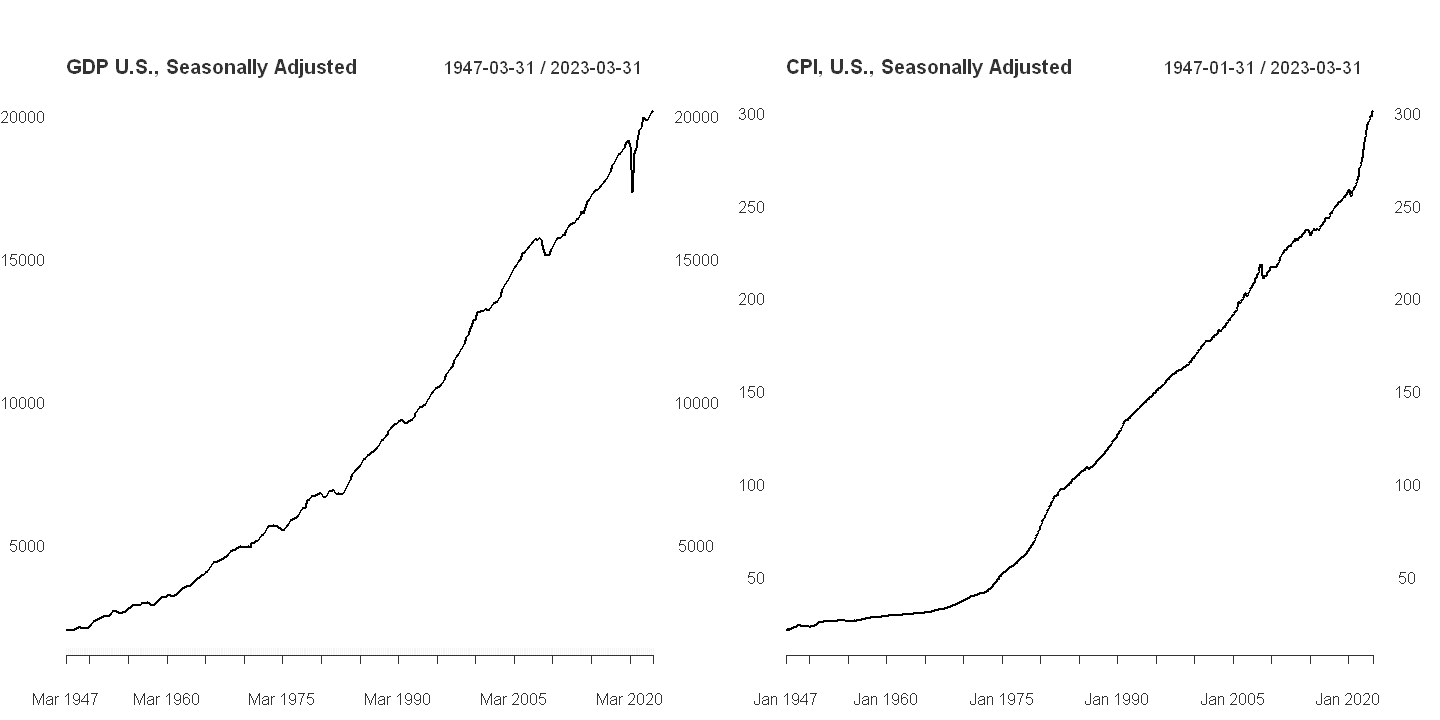

In [2]:
# Set the static variables
us_gdp_id <- "GDPC1" # https://fred.stlouisfed.org/series/GDPC1
us_cpi_id <- "CPIAUCSL" # https://fred.stlouisfed.org/series/CPIAUCSL

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

Both series were available in the seasonally adjusted form, so we could skip step two. In case they were not, however, we appended a `handleSeasonality` function, which would extract the respective components out of the series. This function can be found in our source code, but we will not be using it.

For now, we will just transform the series to logs, as instructed.

[1] "Transforming the series to log..."


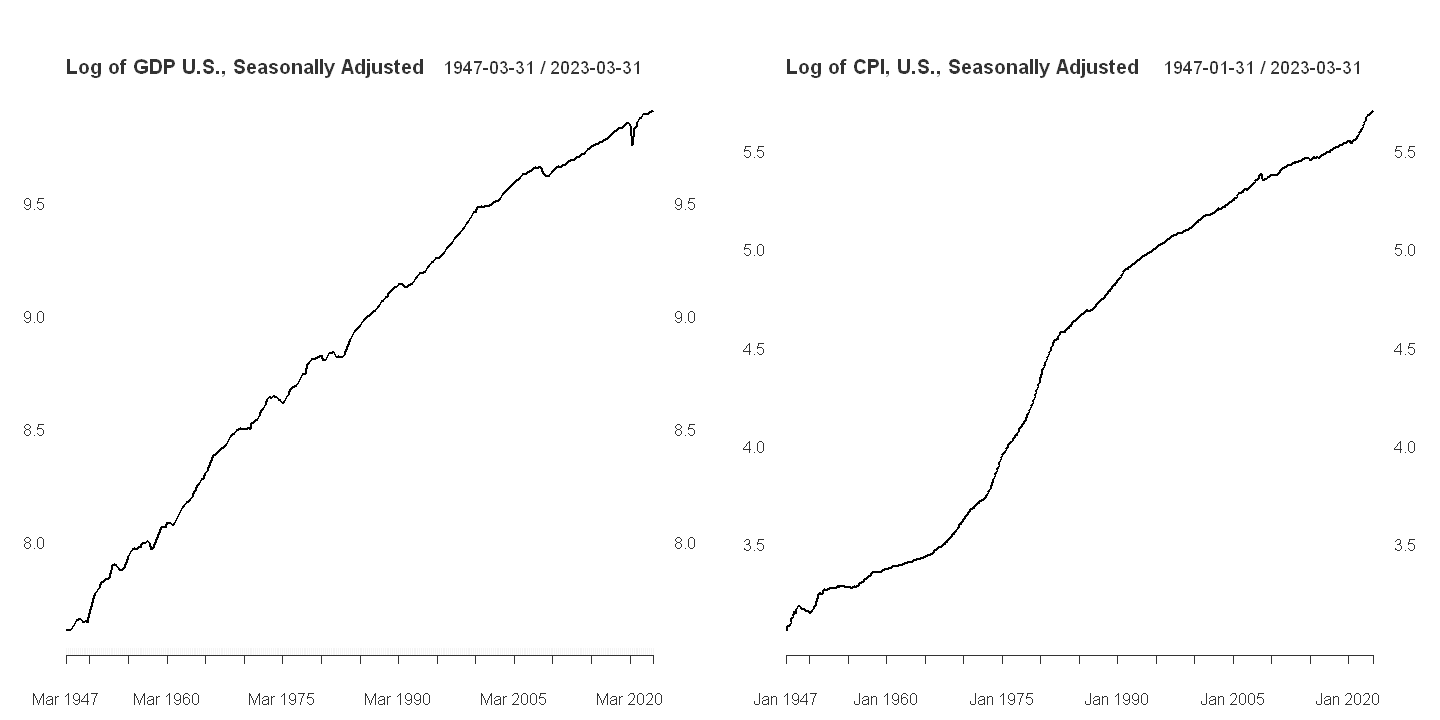

In [3]:
### 1.
print('Transforming the series to log...')
gdp_log <- log(us_gdp_data)
cpi_log <- log(us_cpi_data)

# Plot the new time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(gdp_log, main="Log of GDP U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_log, main="Log of CPI, U.S., Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
### 2.
# gdp_quarterly <- handleSeasonality(gdp_log, "GDP")
# cpi_log <- handleSeasonality(cpi_log, "CPI")

We can **check the data for stationarity, structural breaks, and order of integration**, using a custom function - `runStructuralChecks`.

In [4]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
# runStructuralChecks(gdp_log, "quarterly GDP", print_plots=F) # Commented for the sake of script performance
# runStructuralChecks(cpi_log, "monthly CPI", print_plots=F)

These checks suggest both series are integrated of order one, so **taking the percentage changes could make them stationary**. As for structural breaks with these original series, the tests for breakpoints do not seem to find anything, which could leave us thinking that **there are no major structural breaks** in the source data.

After extracting the seasonal components from the CPI, we can take a look at the Y-O-Y, M-O-M, and P-O-P changes. For GDP, we can not do the M-O-M, because we do not have the data. With CPI, there arise several missing values when computing the percentage change, so we simply remove these, for simplicity. Otherwise, we make good use of a custom function, which allows us to directly compute the percentage changes, while defining the number of periods to look back during the computation.

[1] "Transforming data..."
[1] "Data transformation to percentage changes complete."


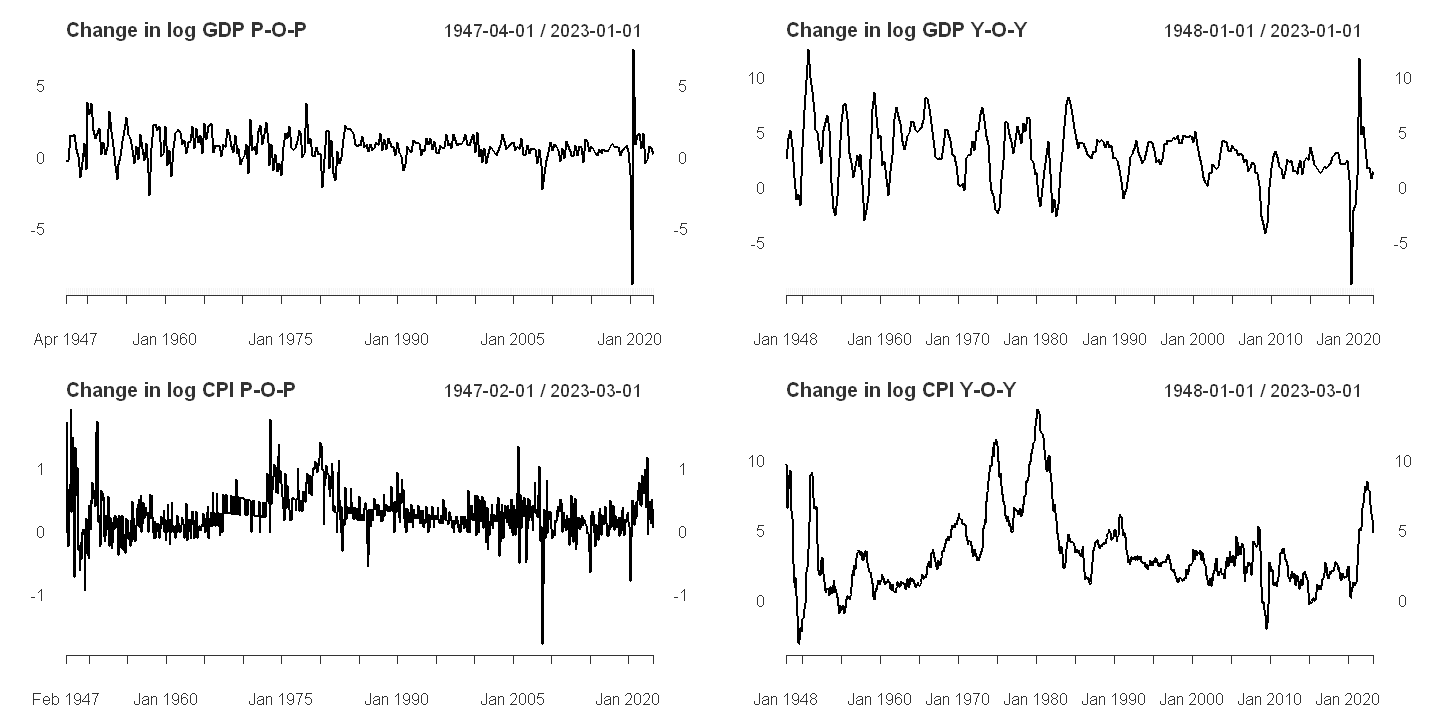

In [5]:
### 3. 
print('Transforming data...')

## First of the period
gdp_log <- ts_first_of_period(gdp_log)
cpi_log <- ts_first_of_period(cpi_log)

# Period-over-period percentage changes
gdp_pop_change <- na.omit(100*diff(gdp_log, 1))
cpi_pop_change <- na.omit(100*diff(cpi_log, 1))

## Calculate month-to-month changes
# Redundant - impossible for GDP due to lack of data, and already in that form for cpi

## Year-over-year percentage changes
gdp_yoy_change <- na.omit(100*diff(gdp_log, 4))
cpi_yoy_change <- na.omit(100*diff(cpi_log, 12))


print('Data transformation to percentage changes complete.')

par(mfrow=c(2,2))
plot.xts(gdp_pop_change, main="Change in log GDP P-O-P", grid.col=NA, yaxis.left=TRUE)
plot.xts(gdp_yoy_change, main="Change in log GDP Y-O-Y", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_pop_change, main="Change in log CPI P-O-P", grid.col=NA, yaxis.left=TRUE)
plot.xts(cpi_yoy_change, main="Change in log CPI Y-O-Y", grid.col=NA, yaxis.left=TRUE)

### *Structural validation of the transformed series*:

With these data, we can take a look at any potential remaining seasonal effects in the m-o-m series of CPI, and p-o-p series of GDP (because there are no monthly GDP data available). Then we check for structural breaks, stationarity, and other characteristics.

In [6]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
# runStructuralChecks(gdp_pop_change, "quarterly GDP") # Commented for the sake of performance
# runStructuralChecks(cpi_pop_change, "monthly CPI")

Both Dickey-Fuller tests suggest stationarity quite strongly, which is the expected outcome. It is good that no double differencing appears to be needed in our case.

Looking at the periodogram of both series, we can spot **no apparent seasonality**. Any repeating patterns emerge in clusters, and not in stand-alone spikes, which is what would happen if strong seasonality was present in the data. 

With both series, higher frequencies are very slightly more common, but certainly not enough to claim that any of the two series is defined only by a limited spectrum of frequencies; far from it.

As for the structural breaks tests, no obvious breakpoints were detected, so we can assume structural integrity.

### *Linear Model Estimation*:

In this section, we will try to estimate several linear models, to see which fit the two series the best. Both of the series should be stationary, so linear models should work just fine in our case. We will model on the monthly data, which allow for the largest granularity. We will run the specification check models on data of other granularity at the end.

The ACF and PACF plots for either series suggest a simple model should suffice, say *ARMA(2,0)* in the case of GDP, and *ARMA(1,0)* in the case of CPI. We will first see what model the `auto.arima` function suggests, to get an idea, and then go on to



In [7]:
auto.arima(gdp_pop_change)
auto.arima(cpi_pop_change)

Series: gdp_pop_change 
ARIMA(4,1,2) 

Coefficients:
         ar1     ar2      ar3      ar4      ma1     ma2
      0.6328  0.0647  -0.0863  -0.0729  -1.5300  0.5375
s.e.  0.3559  0.0775   0.0789   0.0675   0.3549  0.3507

sigma^2 = 1.29:  log likelihood = -467.3
AIC=948.59   AICc=948.97   BIC=974.59

Series: cpi_pop_change 
ARIMA(4,1,1) 

Coefficients:
         ar1      ar2     ar3      ar4      ma1
      0.3126  -0.0608  0.0164  -0.0206  -0.8656
s.e.  0.0721   0.0491  0.0481   0.0515   0.0646

sigma^2 = 0.07371:  log likelihood = -103.12
AIC=218.23   AICc=218.33   BIC=247.13

`auto.arima` suggest *ARIMA(3,1,2)* for the GPD, and *ARIMA(4,1,1)* for CPI. We suppose that the integration of order 1 suggested for both series may arise from the variability in frequencies of the data, but otherwise the data appears stationary, so we do not think it necessary to include the integration order.

To get an idea of which orders might be good to model, we resort to an iterative function `getBoxLjung`, which will create 36 basic ARIMA models, and return the values of their Ljung-Box test, ran on their residuals, understandably. We will then search for a **tradeoff between the number of orders and the large p-value from the test**, as the simpler models are usually the best.

In [8]:
# Get the data frame of p-values from the B-L test
print('Monthly GDP Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(gdp_pop_change)

print('Monthly CPI Ljung-Box test p-values for different orders of ARIMA')
getBoxLjung(cpi_pop_change)

[1] "Monthly GDP Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.7307129,0.3806452,0.5475852
1,2,0.9943552,0.9934988,0.9996015
1,3,0.9801573,0.9947968,0.9939238
1,4,0.9887760,0.9993184,0.9999856
1,5,0.9984913,0.9999096,0.9999985
2,1,0.9900609,0.9859627,0.9987207
2,2,0.7631864,0.4040890,0.6092273
2,3,0.9987113,0.4006390,0.6061047
2,4,0.9587762,0.9864424,0.9840231


[1] "Monthly CPI Ljung-Box test p-values for different orders of ARIMA"


AR order,MA order,1 lag,2 lags,3 lags
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.001634303,0.000002860713,0.0000005865325
1,2,0.913845461,0.988013038078,0.9572764710542
1,3,0.974332681,0.992993570744,0.9899603990336
1,4,0.971092356,0.995197072669,0.9945785924383
1,5,0.941329931,0.996765222170,0.9997898393150
2,1,0.611681115,0.218050025607,0.3845749244130
2,2,0.970378235,0.993935951360,0.9880181691698
2,3,0.848447556,0.926011028255,0.7450935600633
2,4,0.988497045,0.977746542897,0.9407705653265


For GDP, a solid candidate seems to be the *ARMA(1,2)* model, where the residuals perform the best in the Ljung-Box test among models with low order of integration, the model range in which we would ideally like to search. Just as a reminder, we are testing for the autocorrelation of residuals after constructing the model, where the alternative is serial correlation, so high L-B statistic means less likely presence of correlation, which is good. 

So we ran the (1,2) model, but, but found that no coefficients were statistically significant, so maybe autotocorrelation is not the only thing that matters. We were then thinking about the suggested *ARIMA(3,1,2)* model, but the fact that `auto.arima` suggests orders of integration in spite of strong Ljung-Box stationarity hypothesis support, makes us think there might be something inherently incorrect with the function's behavior. We thus chose a close alternative in the ***ARIMA(3,0,1)***, which is what we end up with for GDP.

When it comes to CPI, there was one big concern. No matter the model, we could not get rid of autocorrelation in higher lags of the series, notably around lag 12, which can be seen in both correlation functions below. This would suggest yearly trends in the data, but when we re-checked the seasonality using our `handleSeasonality` function, we got the same results, which only validated that our function is well written, and that **we indeed have seasonally adjusted data from the source**. We decided to not look too deep into this, and proceeded with the modelling as per usual, which led us to the model ***ARIMA(1,0,2)***, the one that showed the best result in the two aforementioned criteria.

Results of the modelling can be seen below.


Call:
arima(x = gdp_pop_change, order = c(3, 0, 1))

Coefficients:
         ar1     ar2      ar3      ma1  intercept
      0.7869  0.0498  -0.1334  -0.6814     0.7551
s.e.  0.2854  0.0788   0.0580   0.2840     0.0694

sigma^2 estimated as 1.266:  log likelihood = -467.19,  aic = 944.38


	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.010786, df = 1, p-value = 0.9173



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.011105, df = 2, p-value = 0.9945



	Box-Ljung test

data:  GDP_ARMA$residuals
X-squared = 0.41463, df = 3, p-value = 0.9372


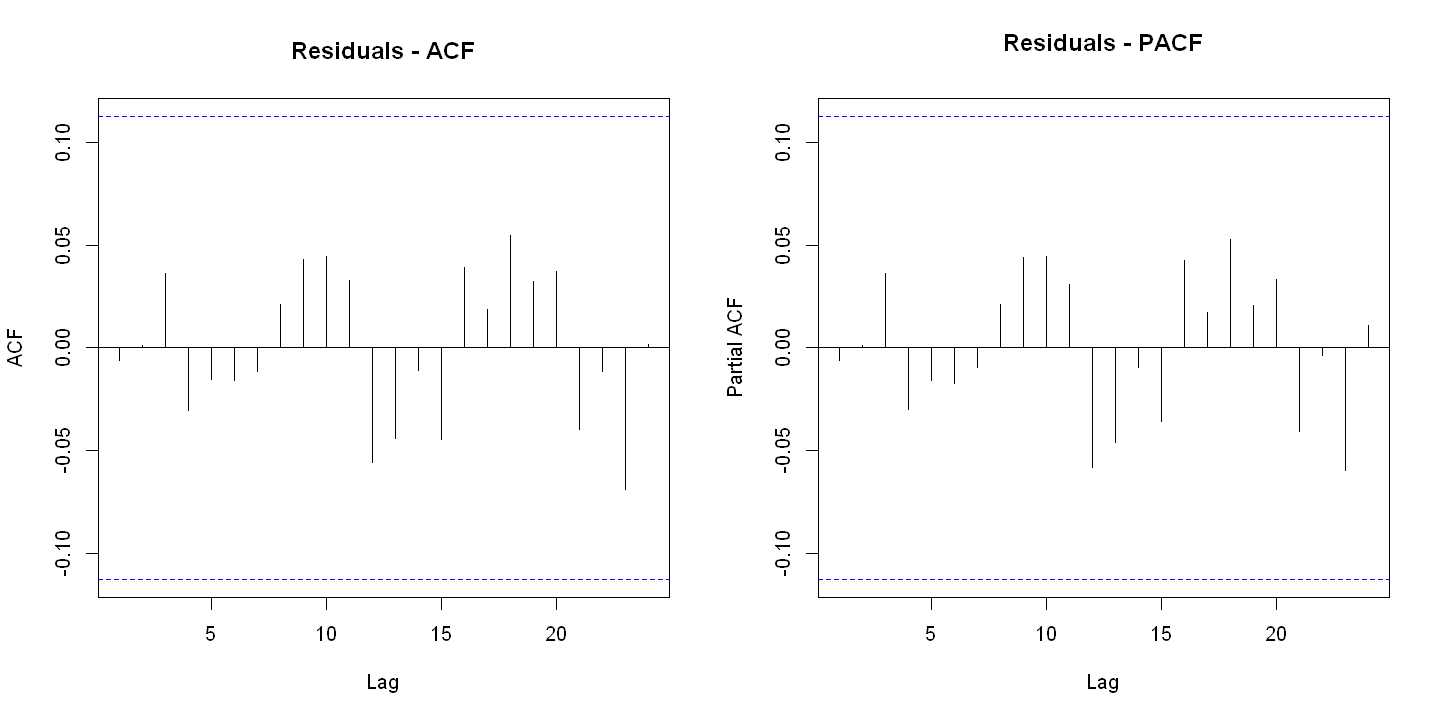

In [9]:
### 4.

## GDP ARMA modelling
GDP_ARMA <- arima(gdp_pop_change, order = c(3, 0, 1))
GDP_ARMA

par(mfrow = c(1, 2))
acf(GDP_ARMA$residuals, main = 'Residuals - ACF')
pacf(GDP_ARMA$residuals, main = 'Residuals - PACF')

Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 1)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 2)
Box.test(GDP_ARMA$residuals, type = "Ljung-Box", lag = 3)


Call:
arima(x = cpi_pop_change, order = c(1, 0, 2))

Coefficients:
         ar1      ma1      ma2  intercept
      0.9616  -0.5311  -0.2303     0.2958
s.e.  0.0134   0.0356   0.0339     0.0541

sigma^2 estimated as 0.07228:  log likelihood = -96.66,  aic = 201.33


	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 0.84973, df = 4, p-value = 0.9317



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 1.9273, df = 8, p-value = 0.9832



	Box-Ljung test

data:  CPI_ARMA$residuals
X-squared = 47.682, df = 12, p-value = 0.000003551


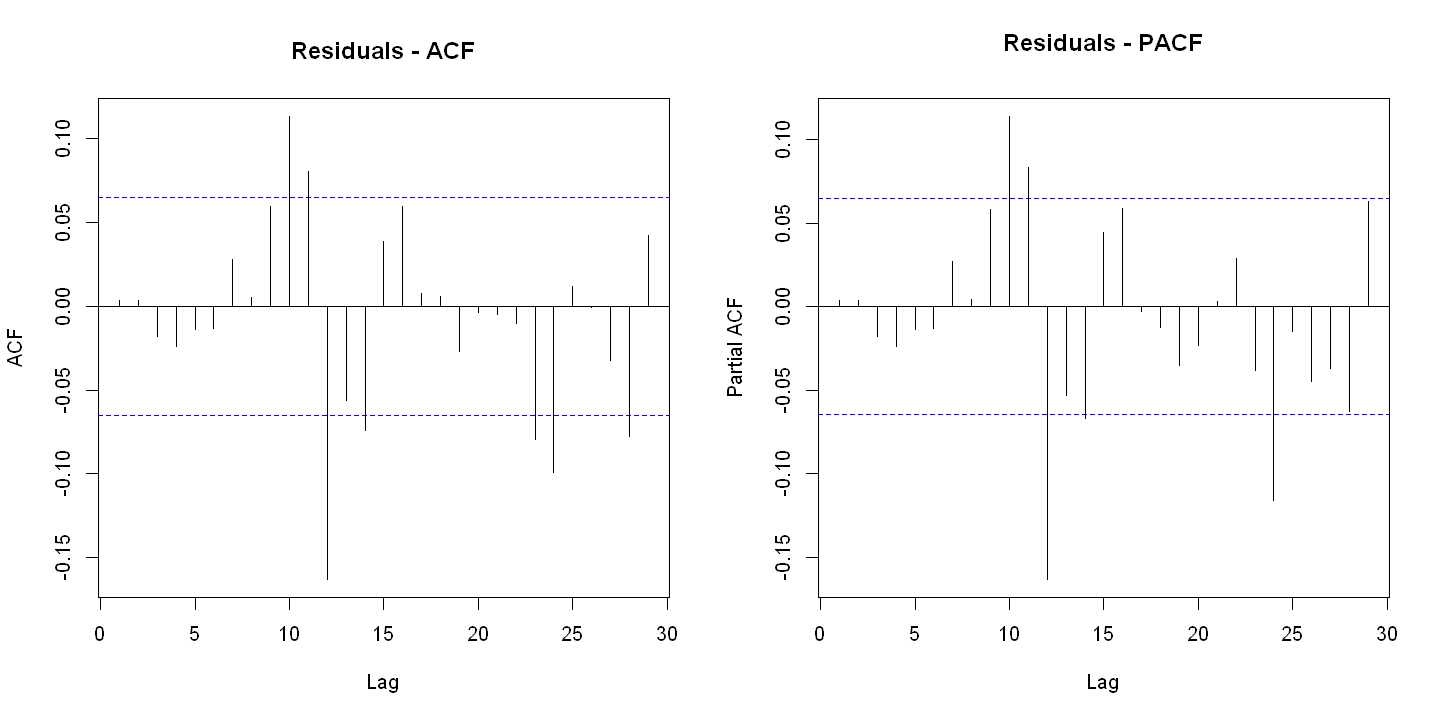

In [10]:
## CPI ARMA modelling
CPI_ARMA <- arima(cpi_pop_change, order = c(1, 0, 2))
CPI_ARMA

par(mfrow = c(1, 2))
acf(CPI_ARMA$residuals, main = 'Residuals - ACF')
pacf(CPI_ARMA$residuals, main = 'Residuals - PACF')

Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 4)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 8)
Box.test(CPI_ARMA$residuals, type = "Ljung-Box", lag = 12)


The residuals seem well behaved in both cases, although there is the peculiar persistence in the 12th lag in the CPI residuals, as we mentioned. We did a bit of exploration, but the seasonality trend should be gone, so we suspect this may be caused by some outliers in the series.

Now let's **run some forecasts**. This can be done using the `forecast` package.


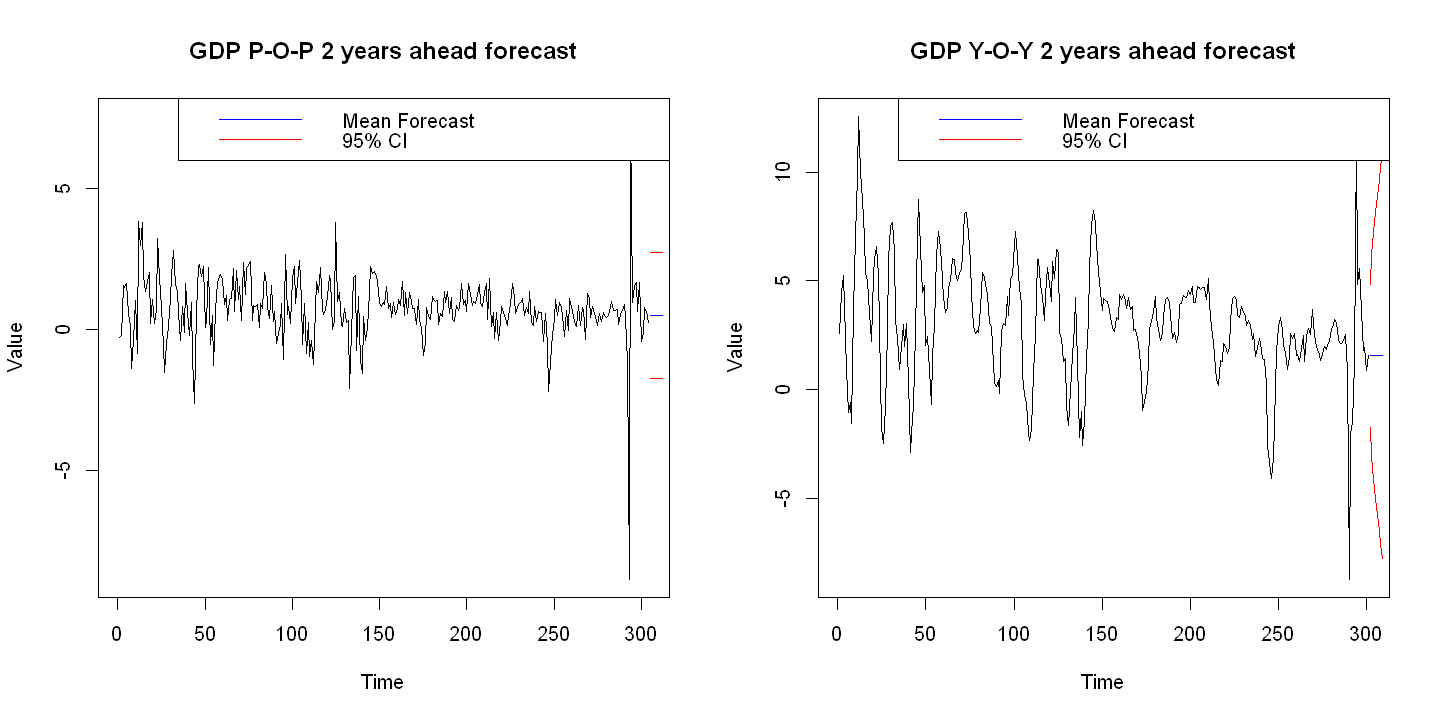

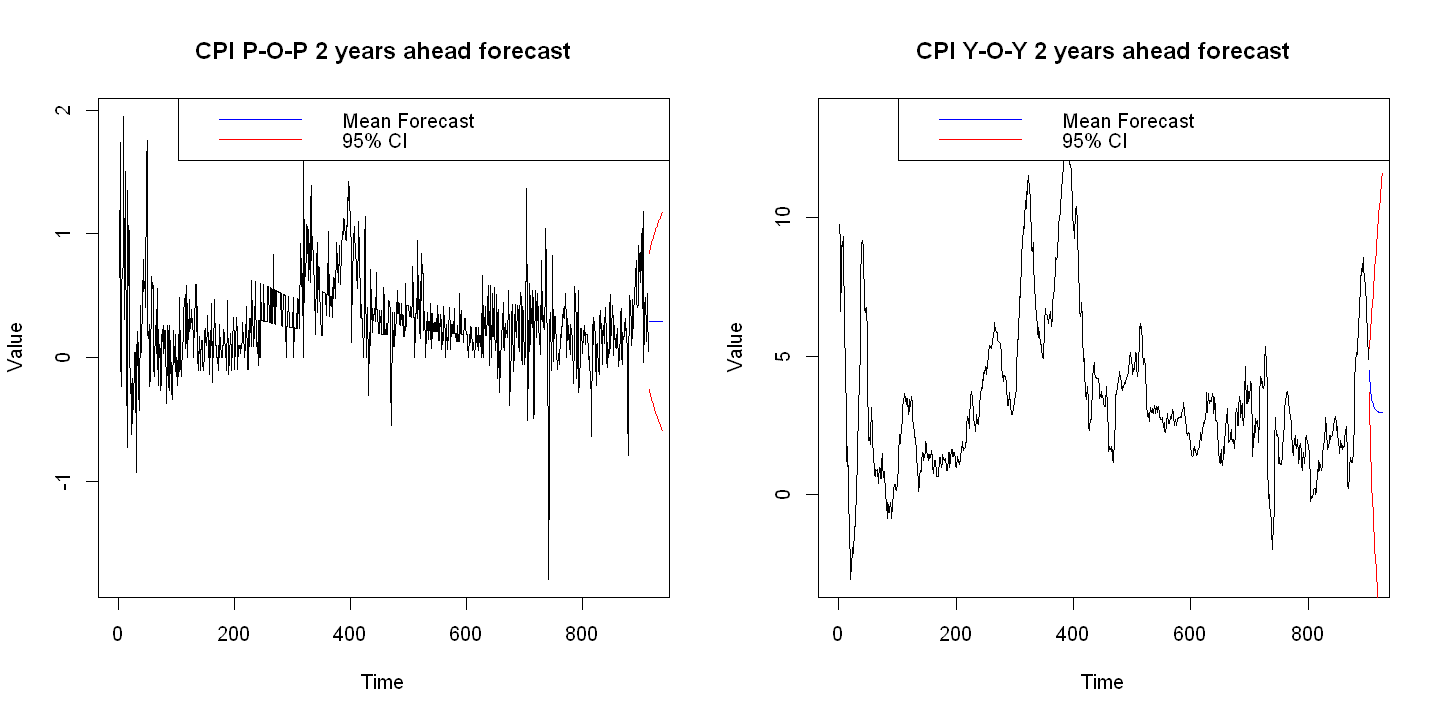

In [11]:
## Forecast 2 years ahead

# Forecast GDP
par(mfrow = c(1,2))
gdp_pop_forecast <- forecastData(gdp_pop_change, periods=8, date_frequency="quarter", series_name="GDP P-O-P")
gdp_yoy_forecast <- forecastData(gdp_yoy_change, periods=8, date_frequency="quarter", series_name="GDP Y-O-Y")

# Forecast CPI
par(mfrow = c(1,2))
cpi_pop_forecast <- forecastData(cpi_pop_change, periods=24, date_frequency="month", series_name="CPI P-O-P")
cpi_yoy_forecast <- forecastData(cpi_yoy_change, periods=24, date_frequency="month", series_name="CPI Y-O-Y")


Now, we are able to run 2 forecasts for each series only - first, it's monthly for CPI, and quarterly for GDP, and then we have yearly for each of these two. This should be most sufficient, and in the case of GDP, we do not have the data to do more.

As for the forecasts themselves **we choose to run a very simple form, using the `forecast` package**. A rolling or expanding forecast could also make sense, to account for the new, forecasted data, but we may consider doing that in the future.

As for the results, it seems that in the P-O-P case, the forecasts just predict a linear continuation of the series in both cases, without much change, while in the Y-O-Y case, the suggested forecasts tend toward mean reversal, although that is just us judging by a quick glance.

### *Estimating the Output Gap*:

##### Hodrick-Prescott Filter:

We will start with obtaining the Hodrick-Prescott filter, and observing its various specifications.

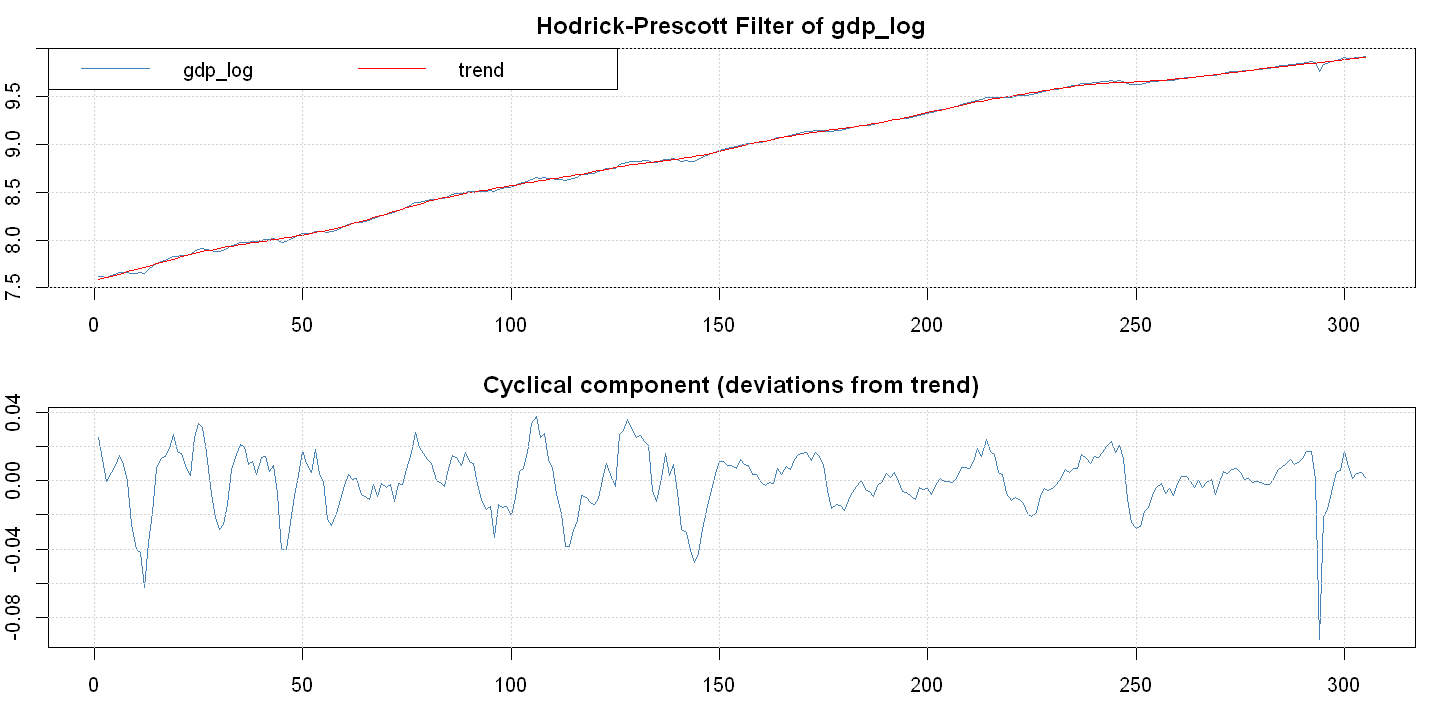

In [12]:
### 5.

# Hodrick-Prescott filter
hp <- hpfilter(gdp_log, freq=1600, type="lambda") # Source data have seasonality removed
hp_OG <- as.xts(hp$cycle, order.by=index(gdp_log)) # Output gap
plot(hp)

To run the structural checks, we will make use of the function we defined before - `runStructuralChecks`.  We take a look at the structural specifications of the output gap, and make forecasts.

[1] "Running structural checks for the GDP Output Gap"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for the GDP Output Gap..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -6.7517, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


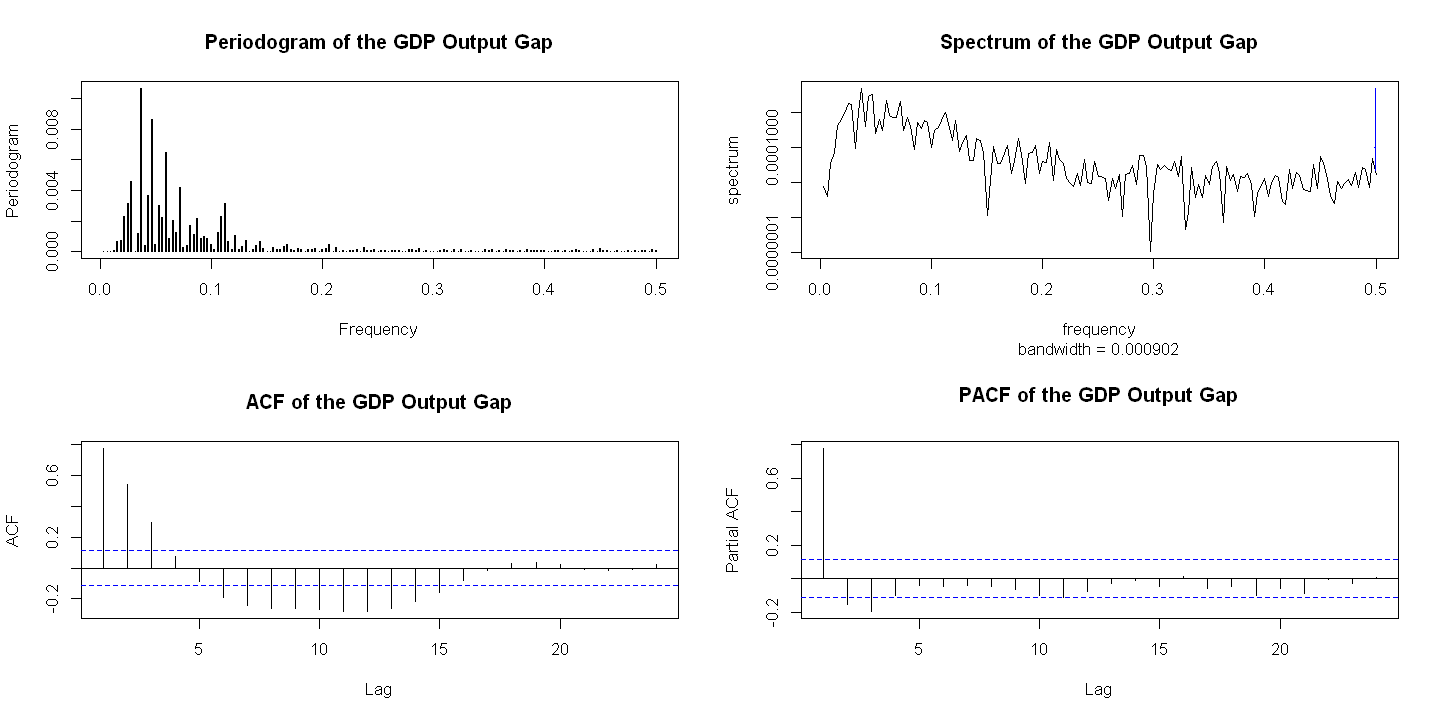

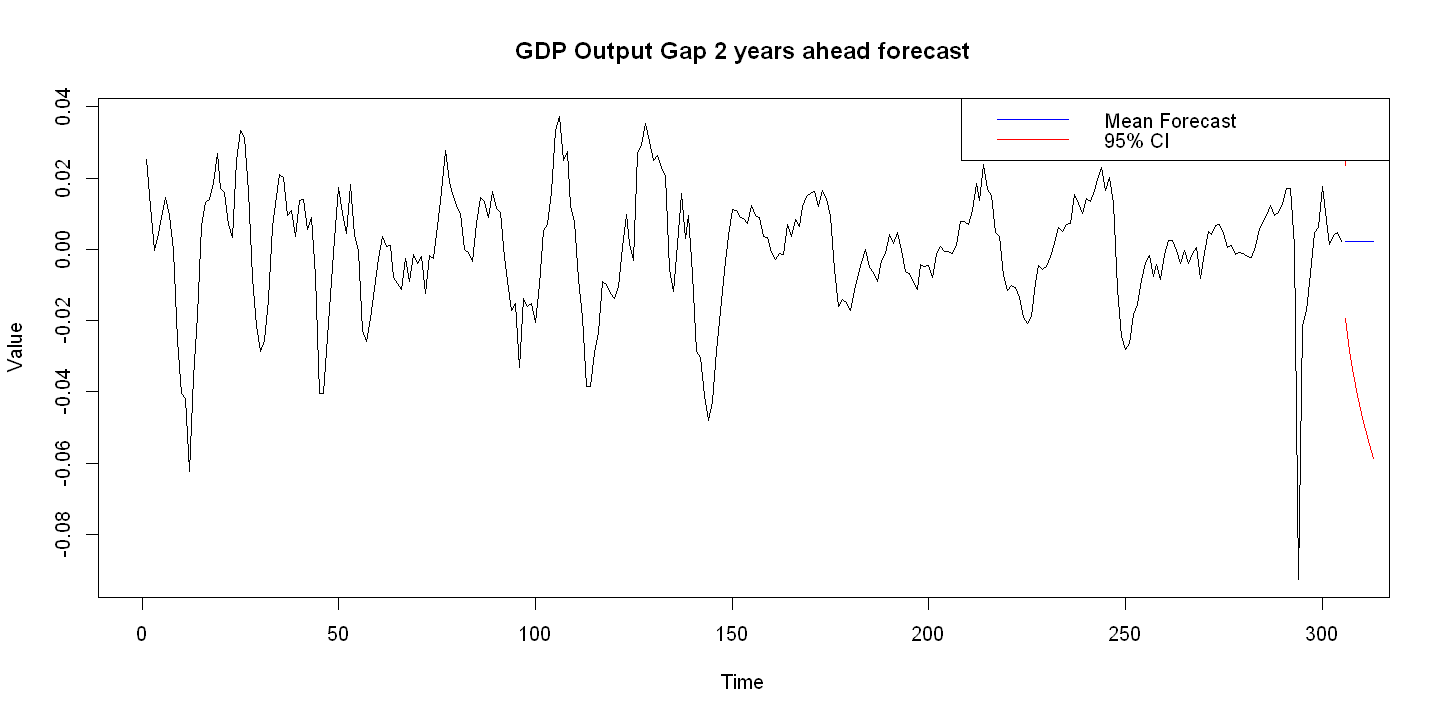

In [13]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(hp_OG, "the GDP Output Gap")

# Forecast using the GDP trend

par(mfrow=c(1,1))
hp_forecast <- forecastData(hp_OG, periods=8, date_frequency="quarter", series_name="GDP Output Gap")

For the Hodrick-Prescott filter, we set the smoothing parameter to $\lambda = 1600$, as that is the best practice, as far as we remember. The series appears stationary, with no major structural breaks within.

The forecast function shows us nothing interesting at first glance, as the mean forecast remains almost unchanging, with a considerably wide confidence interval. Furthermore, given the large relative deviations of the quarter-over-quarter differences, which we use for forecasting, it may be naive to assume such small deviation for the forecast, but that is just our personal opinion.

##### Hamilton's regression filter

Next we move onto the *Hamilton's regression filter*. Building the filter is straightforward, and afterwards we use the same methodology for estimation as in the case of the H-P filter.

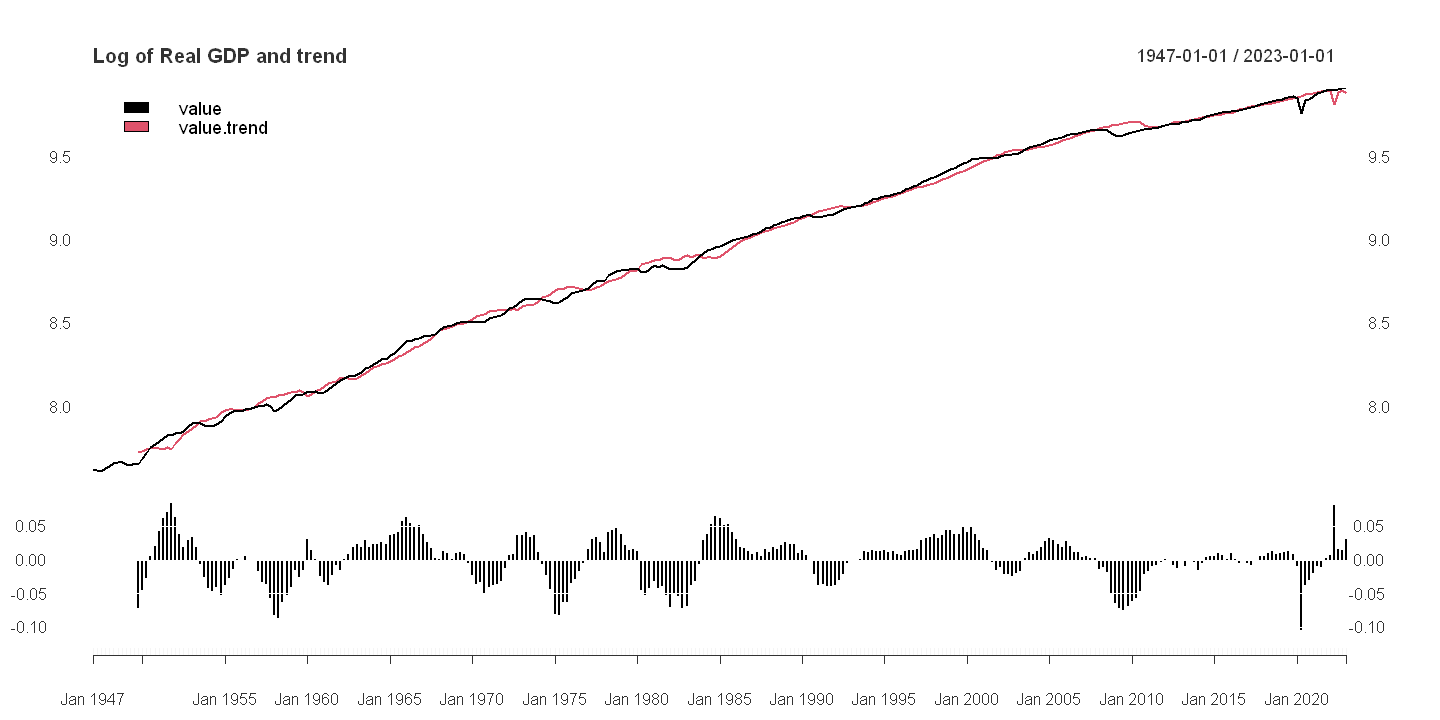

In [14]:
# Hamilton filter
gdp_HAM <- yth_filter(gdp_log, h= 8, p = 4)
ham_OG <- na.omit(gdp_HAM[,3])
par(mfrow=c(1,1))
plot(gdp_HAM[,1:2], grid.col = "white", legend.loc = "topleft", main = "Log of Real GDP and trend", panels = 'lines(gdp_HAM[,3], type="h", on=NA)')

[1] "Running structural checks for GDP Output Gap"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for GDP Output Gap..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -4.586, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


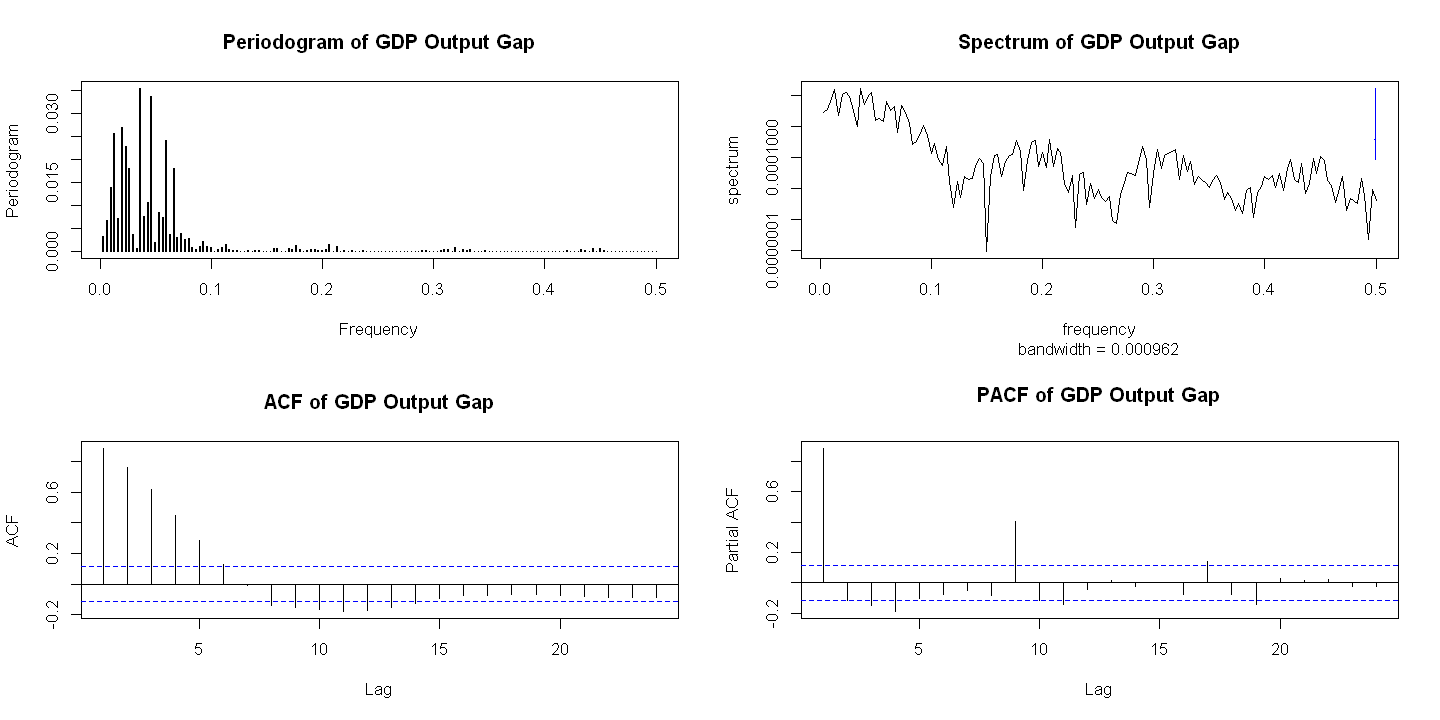

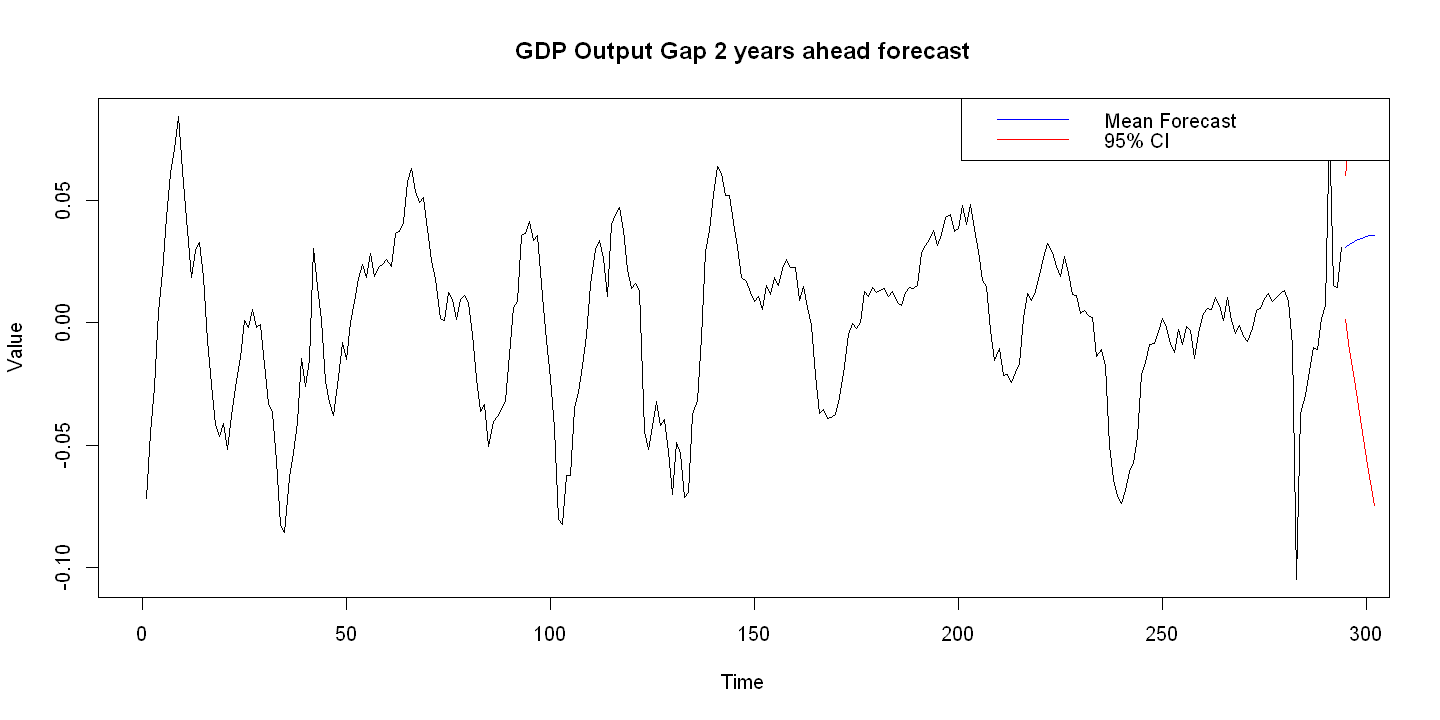

In [15]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(ham_OG, "GDP Output Gap")

# Forecast using the GDP trend

par(mfrow=c(1,1))
ham_OG_forecast <- forecastData(ham_OG, periods=8, date_frequency="quarter", series_name="GDP Output Gap")

The results do not vary much, perhaps with the exception of a slightly more pessimistic forecast for the 2-years-ahead period.

Again, the series appears strongly stationary, with no apparent structural breaks.

___

# 2nd Stage

## Analyze propagation of macroeconomic shocks

### 1) Data and the choice of the shock

For this task, I have been explicitly asked not to use monetary policy shock, due to its usage during the exercises. As such, I chose to **observe these two shocks - shock to oil prices** (as it has had a significant impact on the U.S. economy historically), and **the uncertainty shock**.

For the data source, I decided to use the Federal Reserve Economic Data (FRED) website, as I did in the previous section of the paper.

When it comes to the time sample and periodization, **I will download and transform the data so that it corresponds to the already obtained data from the previous section - time range from Jan 1948 to Dec 2022, with a y-o-y percentage change.**

 More comments here maybe

Now that all is set, let us move onto the actual data transformation process. First we will **download the data for the two new time series** and transform it so that it follows the same format as the original GDP/inflation data.

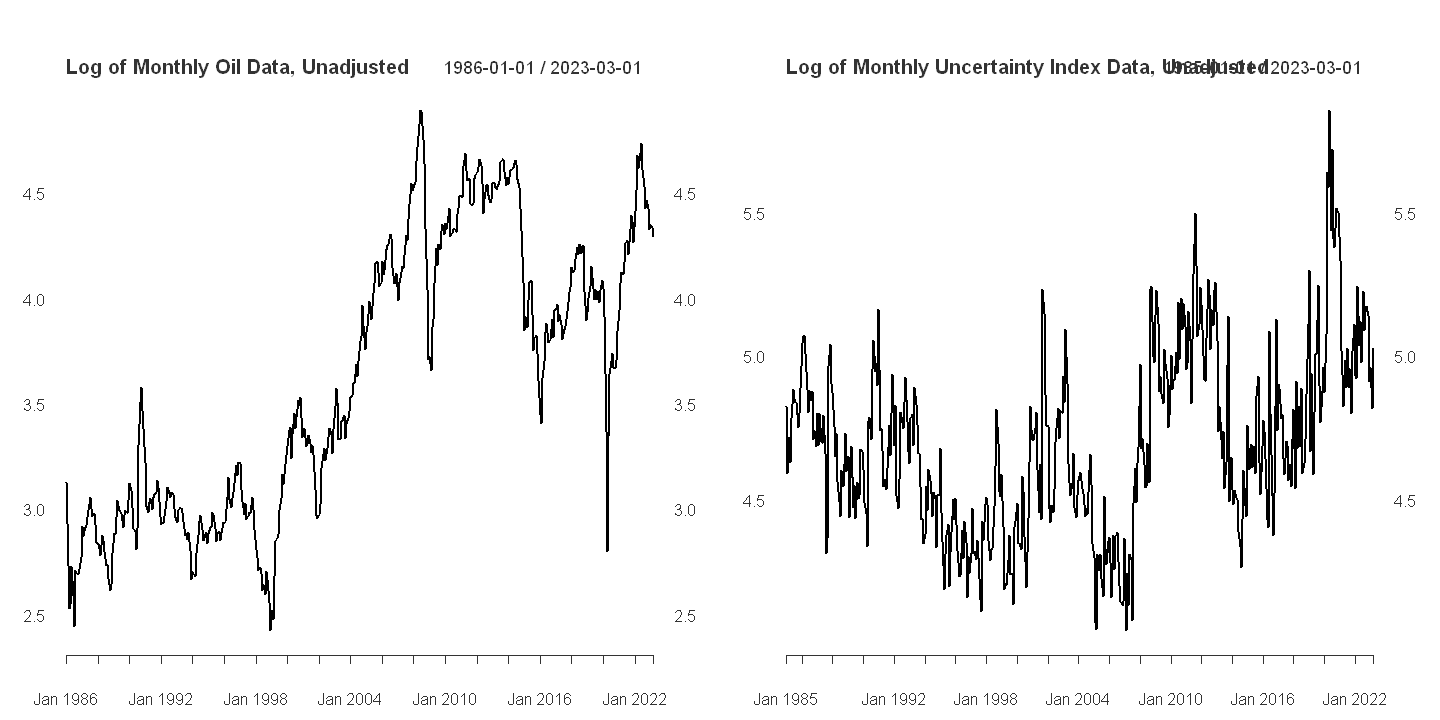

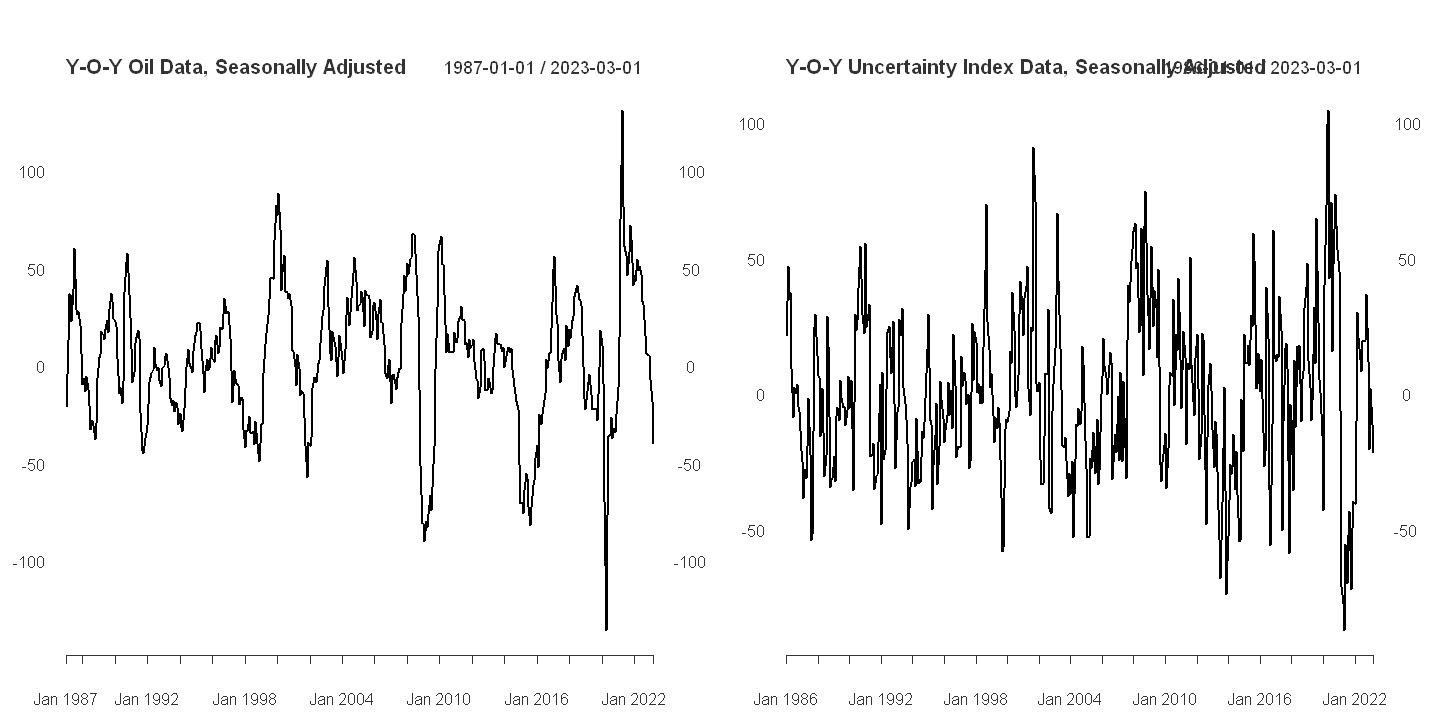

In [16]:
# Oil prices data
oil_data <- pdfetch_FRED("MCOILWTICO") # Monthly oil data, seasonally unadjusted
oil_data <- ts_first_of_period(oil_data) # First of period
oil_data_log <- log(oil_data) # To log
oil_data_seas <- handleSeasonality(oil_data_log, "oil_prices") # Adjust for seasonality
oil_data_yoy_change <- na.omit(100*diff(oil_data_seas, 12)) # Transform to y-o-y changes

# Economic Policy Uncertainty Index
uncertainty_index_data <- pdfetch_FRED("USEPUINDXM") # Monthly uncertainty index data, seasonally unadjusted
uncertainty_index_data <- ts_first_of_period(uncertainty_index_data) # First of period
uncertainty_index_data_log <- log(uncertainty_index_data) # To log
uncertainty_index_data_seas <- handleSeasonality(uncertainty_index_data_log, "uncertainty_index") # Adjust for seasonality
uncertainty_index_data_yoy_change <- na.omit(100*diff(uncertainty_index_data_seas, 12)) # Transform to y-o-y changes

# Plot the two original series
par(mfrow=c(1,2))
plot.xts(oil_data_log, main="Log of Monthly Oil Data, Unadjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(uncertainty_index_data_log, main="Log of Monthly Uncertainty Index Data, Unadjusted", grid.col=NA, yaxis.left=TRUE)

# Plot the two transformed series
par(mfrow=c(1,2))
plot.xts(oil_data_yoy_change, main="Y-O-Y Oil Data, Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)
plot.xts(uncertainty_index_data_yoy_change, main="Y-O-Y Uncertainty Index Data, Seasonally Adjusted", grid.col=NA, yaxis.left=TRUE)

### 2) Appropriate Transformations and Ordering of Variables

Now let's prepare the data frame, which will serve in the identification process. We will use an unified index, which will be **quarterly, starting in Jan 1987, and ending in Dec 2022**. This is the period for which all data are available, and thus will **serve as the common denominator**. As such, we will receive a unified xts object of quarterly y-o-y change data for the following four variables - GDP growth, Inflation, Oil Prices, and Economic Policy Uncertainty Index.

It is here, during the construction of the data set, that the default ordering for our variables will be set (of course, we can change it later on, but it will be convenient to construct the data frame in the ordered way right off the bat). Let us thus **consider the causal relationship among variables**:
* GDP afftects all other variables contemporaneously
* Inflation affects all variables but GDP growth
* Uncertainty index affects oil prices only

As for the contemporaneous relationship restrictions in the SVAR model that will help us with identification, we will leave those for later. For now, let us assume this simple, ordered contemporaneous causal relationship that we outlined, and order the variables as follows:
1. GDP growth
2. Inflation
3. Change in uncertainty index
4. Change in oil prices

In [17]:
# Get the unified index
data_var_index <- index(gdp_yoy_change['1987/2022'])

# # Create the "data_var" main .xts object using GDP growth
data_var_orig <- gdp_yoy_change[data_var_index] # GDP growh
colnames(data_var_orig) <- "gdp_growth"

# Append the rest of the data
data_var_orig$inflation <- cpi_yoy_change[data_var_index] # Inflation data
data_var_orig$uncertainty_index <- uncertainty_index_data_yoy_change[data_var_index] # Uncertainty index data
data_var_orig$oil_prices <- oil_data_yoy_change[data_var_index] # Oil data

# Print to console
print(data_var_orig)

            gdp_growth   inflation uncertainty_index  oil_prices
1987-01-01    2.679616    1.355647        -24.446859  -20.659995
1987-04-01    3.303314    3.613763        -30.480852   37.488813
1987-07-01    3.214697    3.851797        -21.699106   61.044059
1987-10-01    4.381609    4.263523         25.294545   28.734645
1988-01-01    4.154675    4.046286          7.421270   -8.501483
1988-04-01    4.386955    3.915246          2.491064   -4.488986
1988-07-01    4.107348    4.047044        -22.192683  -31.974322
1988-10-01    3.728587    4.172593        -33.982037  -36.621535
1989-01-01    4.224728    4.385188        -22.449223    5.065094
1989-04-01    3.679752    4.911516         -4.308540   16.528665
       ...                                                      
2020-07-01  -2.0447739   1.0090306        71.3011366 -34.2699081
2020-10-01  -1.5282382   1.1755976        74.3336376 -31.4477215
2021-01-01   1.1848875   1.3851439        45.8938638 -10.0888995
2021-04-01  11.7435014   

Interestingly, the new data seems way more volatile in terms of scale. While most percentage changes for GDP growth or inflation stay in the low single digits, sudden doubling or complete dwindling of the oil prices of the uncertainty index over the year are not uncommon. The difference in scales could have a negative impact on the identification, regression, and forecasting, so we decided to standardize the data, so that the output is more clear, and easily readable. First we run some structural checks, however.

We know that the data for GDP growth and Inflation is stationary, so let us just run a quick check for the oil prices and the uncertainty index too.

In [18]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(data_var_orig$oil_prices, "Quarterly Y-O-Y change in oil prices", print_plots=F)
runStructuralChecks(data_var_orig$uncertainty_index, "Quarterly Y-O-Y change in the uncertainty index", print_plots=F)

[1] "Running structural checks for Quarterly Y-O-Y change in oil prices"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for Quarterly Y-O-Y change in oil prices..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -5.547, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"
[1] "Running structural checks for Quarterly Y-O-Y change in the uncertainty index"
[1] "Testing for breakpoints..."


Extracting statistics...



  |======================================================================| 100%
statcheck did not find any results
[1] "Running the augmented Dickey-Fuller test for Quarterly Y-O-Y change in the uncertainty index..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -6.3307, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The transformed series is stationary and has zero order of integration"


The results seem stable, both for structural integrity, and stationarity, so we can move onto standardization. This is done using the `tidyverse::scale` function. We do not care much about the magnitude of the effects, but mainly for direction and statistical significance. If we wanted to interpret the results numerically one day, we could simply undo the standardization and interpret the original numbers.

In [19]:
# Scale all columns
data_var_scaled <- apply(data_var_orig, MARGIN = 2, scale)

# Back to an .xts object
data_var <- as.xts(data_var_scaled, order.by = index(data_var_orig))

# Print out the result into the console
print(data_var)

              gdp_growth     inflation uncertainty_index    oil_prices
1987-01-01  0.1025044986 -0.8605400583     -0.7920835283 -0.7254672786
1987-04-01  0.4045504046  0.5719718843     -0.9836340748  0.9140418155
1987-07-01  0.3616344799  0.7229771141     -0.7048554858  1.5781833519
1987-10-01  0.9267494536  0.9841693101      0.7869690294  0.6672175062
1988-01-01  0.8168493671  0.8463578322      0.2195777303 -0.3826573224
1988-04-01  0.9293381862  0.7632277207      0.0630671615 -0.2695247142
1988-07-01  0.7939296424  0.8468383949     -0.7205241788 -1.0444754005
1988-10-01  0.6105025385  0.9264849326     -1.0947799996 -1.1755038286
1989-01-01  0.8507747885  1.0613516541     -0.7286680973 -0.0001468717
1989-04-01  0.5868524694  1.3952451252     -0.1527878768  0.3230691974
       ...                                                            
2020-07-01   -2.18543346   -1.08042758        2.24745911   -1.10919958
2020-10-01   -1.93528445   -0.97476023        2.34372657   -1.02962786
2021-0

With transformation in place, let us move onto

### 3) Identification

We first make use of the `VARselect` function for lag length selection. Afterwards, we will construct the Vector Autoregression model using the suggested number of lags, and using this model, we will discuss the issue of identification.


In [20]:
# Selectign the optimal number of lags
var1.select <- VARselect(data_var, lag.max=8, type="const")
print(var1.select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     8      1      1      8 


In [21]:
# We run the vector autoregression using the suggested number of lags.
var1 <- VAR(data_var, p=8, type="const")

The suggested lag number is split equally between 1 and 8, which is the maximum number of permitted lags (2x the variable count). Our intuition suggests using 8 lags, so that what we constructed the VAR using.

Now we can move onto the *Cholesky decomposition*. Here, the identification will be handled implicitly through the ordering the variables. The variables unaffected by others will come first in the system, while the most endogenous variables will come last. This will, after constructing the lower-triangular matrix, determine the identification of structural shocks.

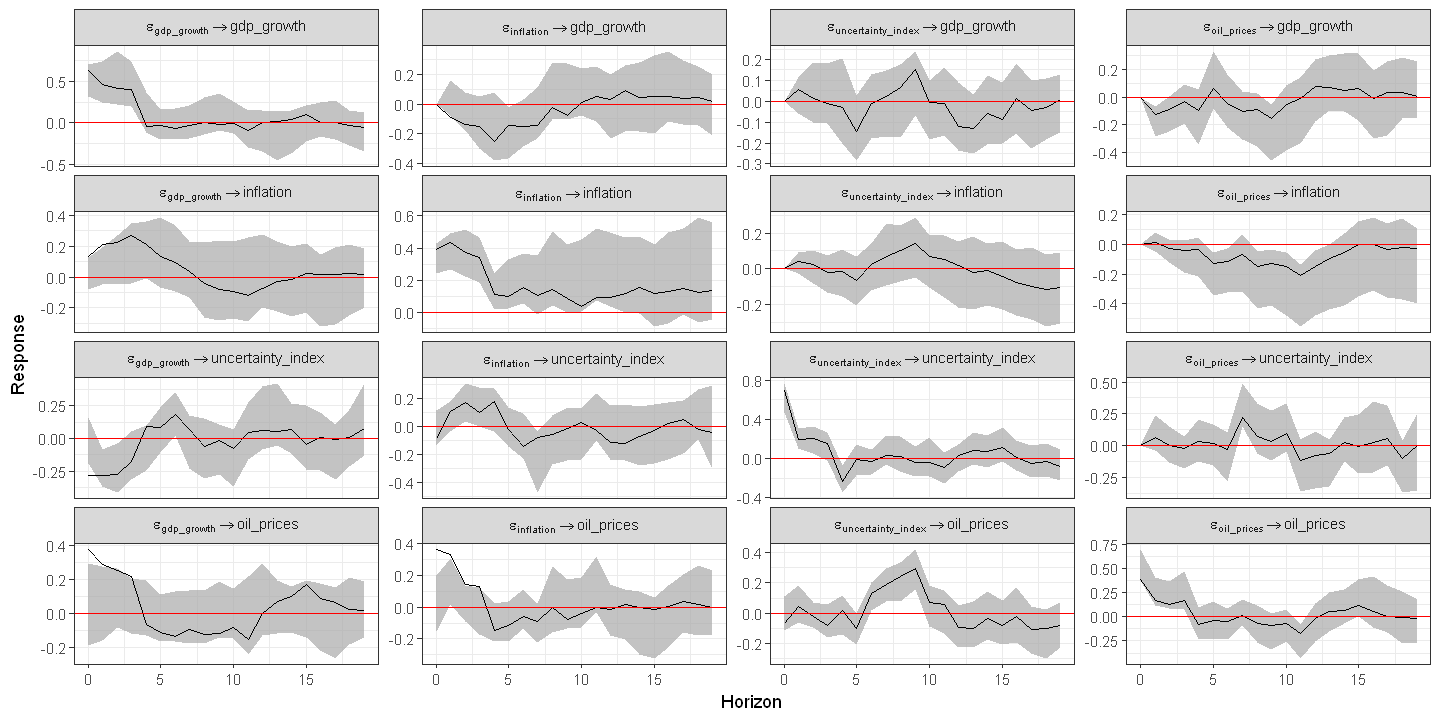

In [22]:
var1_cholesky <- id.chol(var1)
var1_cholesky_svarsirf <- irf(var1_cholesky, n.ahead = 20)
var1_bootirf <- wild.boot(var1_cholesky, design = "fixed", distr = "gaussian", n.ahead = 20, nboot = 100)
plot(var1_bootirf, lowerq = 0.05, upperq = 0.95)

With the Cholesky decomposition, we were able to achieve identification quite easily, and the VAR Impulse Response Functions can be seen in the plots above. For most of the shock resopnses, we can not claim a clear/signification impact. All of the variables have, however, a clear, positive reponse to shocks in themselves, in the short run. This makes sense, as any shock to a variable can be expected to come with a bit of friction before it reverts back to the mean, whether the shock is in this or that direction.

There are some obvious relationships, such as shock in the inflation making oil prices rise, or growth in GDP causing slight, short term rise in inflation. Also it is good to note, that the uncertainty index and oil prices should not be interpreted as such, because we transformed them into percentage year-over-year changes. So the representation would be something like "change in oil prices", or "change in the uncertainty index".

___

The Cholesky decomposition procedure itself is simple, as it requires no additional assumptions from our side. The same is not true for the *SVAR model*, which requires imposing restrictions on the contemporanous causal relationships among variables. Let us **define the structural matrix**, that will serve us for this imposition.

As for the choice of restrictions, our reasoning is as follows - we would assume that GDP growth and inflation might be simultaneously influenced by each other and oil prices, while the uncertainty index is assumed to have no direct contemporaneous effect on GDP growth or inflation. These stem from intuition, as well as macroeconomic theory - Bloom (2009), Blanchard and Gali (2007), or Barsky and Kilian (2004).

To explain a bit more in detail, we would guess that there is a contemporaneous effect of GDP growth on inflation or vice versa. This captures the possibility that, in the short run, changes in GDP growth could impact inflation or that inflation could impact GDP growth. For example, an unexpected increase in demand could cause both GDP growth and inflation to rise simultaneously.

Furthermore, changes in oil prices can have an immediate impact on inflation due to their effect on production costs and consumer prices. Conversely, changes in inflation could impact oil prices through changes in the overall price level or shifts in demand for oil.

Consequently, the structural identification matrix looks as follows:

In [23]:
BMat = diag(4)
BMat[2,1] <- NA
BMat[2,4] <- NA
BMat[3,4] <- NA
BMat[4,1] <- NA
BMat[4,2] <- NA
BMat[4,3] <- NA
print(BMat)

     [,1] [,2] [,3] [,4]
[1,]    1    0    0    0
[2,]   NA    1    0   NA
[3,]    0    0    1   NA
[4,]   NA   NA   NA    1


Reason about the restrictions here.

It is important that we keep the number of restrictions to the number of coefficients under the diagonal, which in this case is 6.

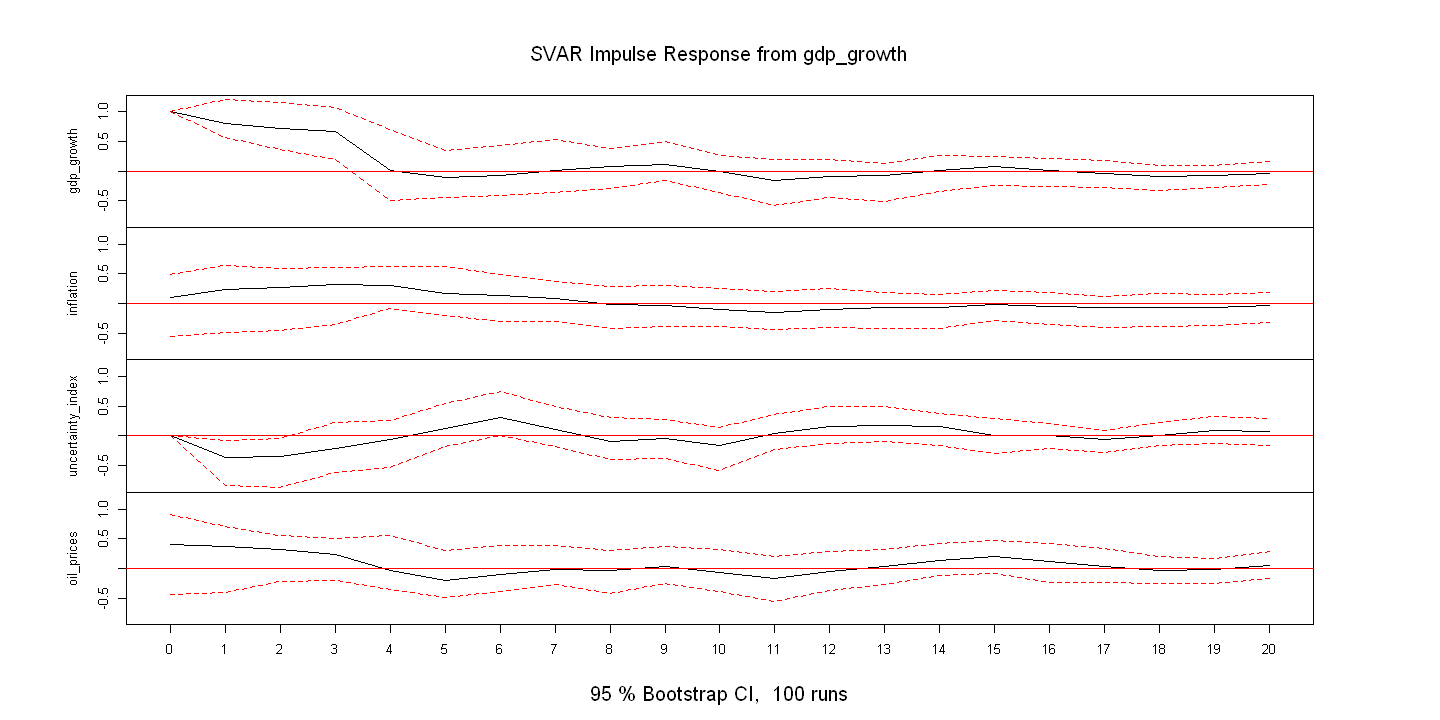

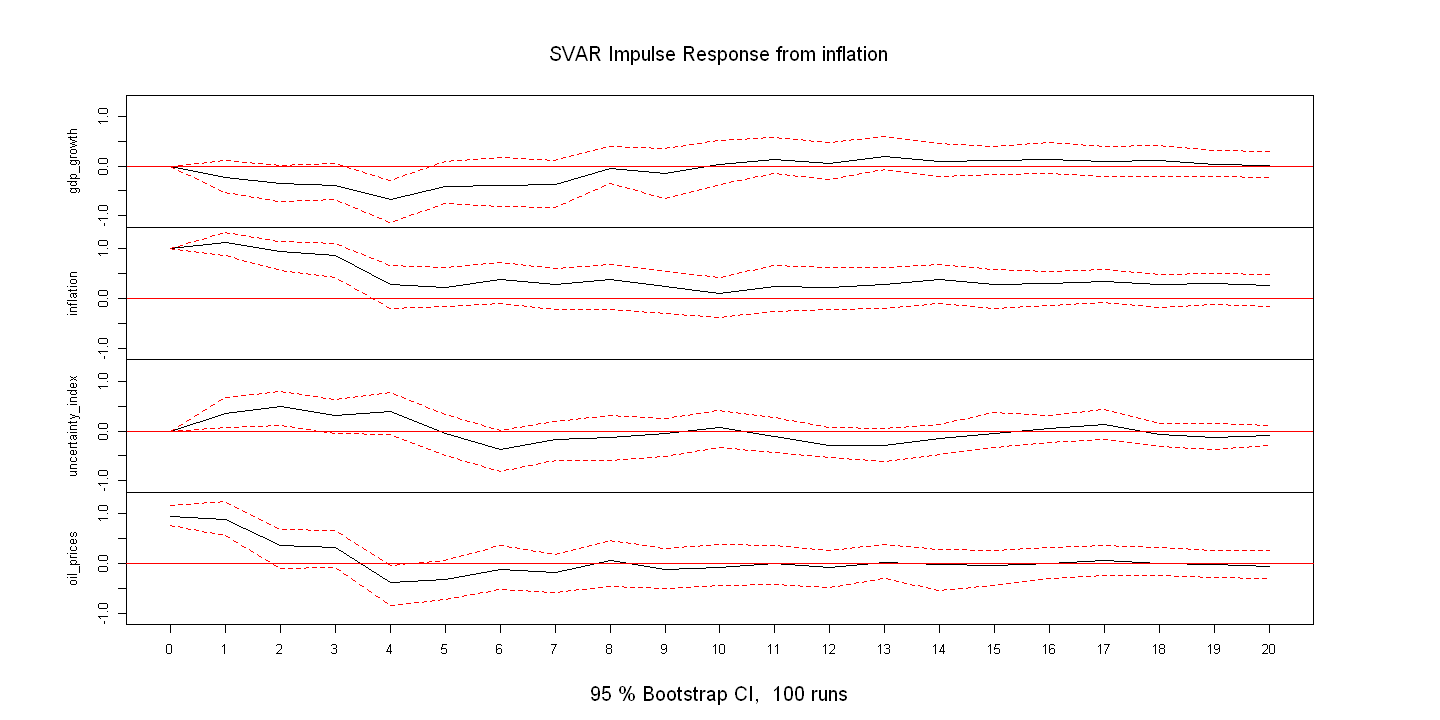

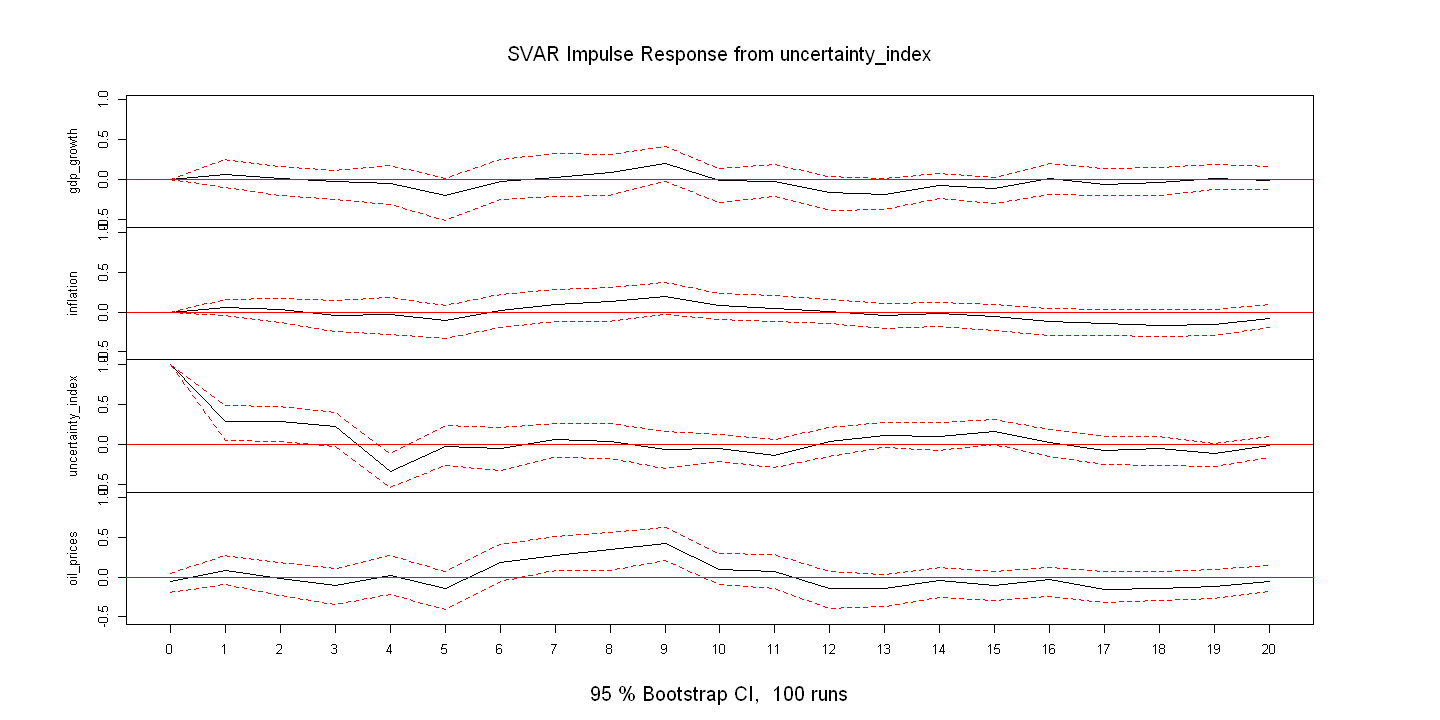

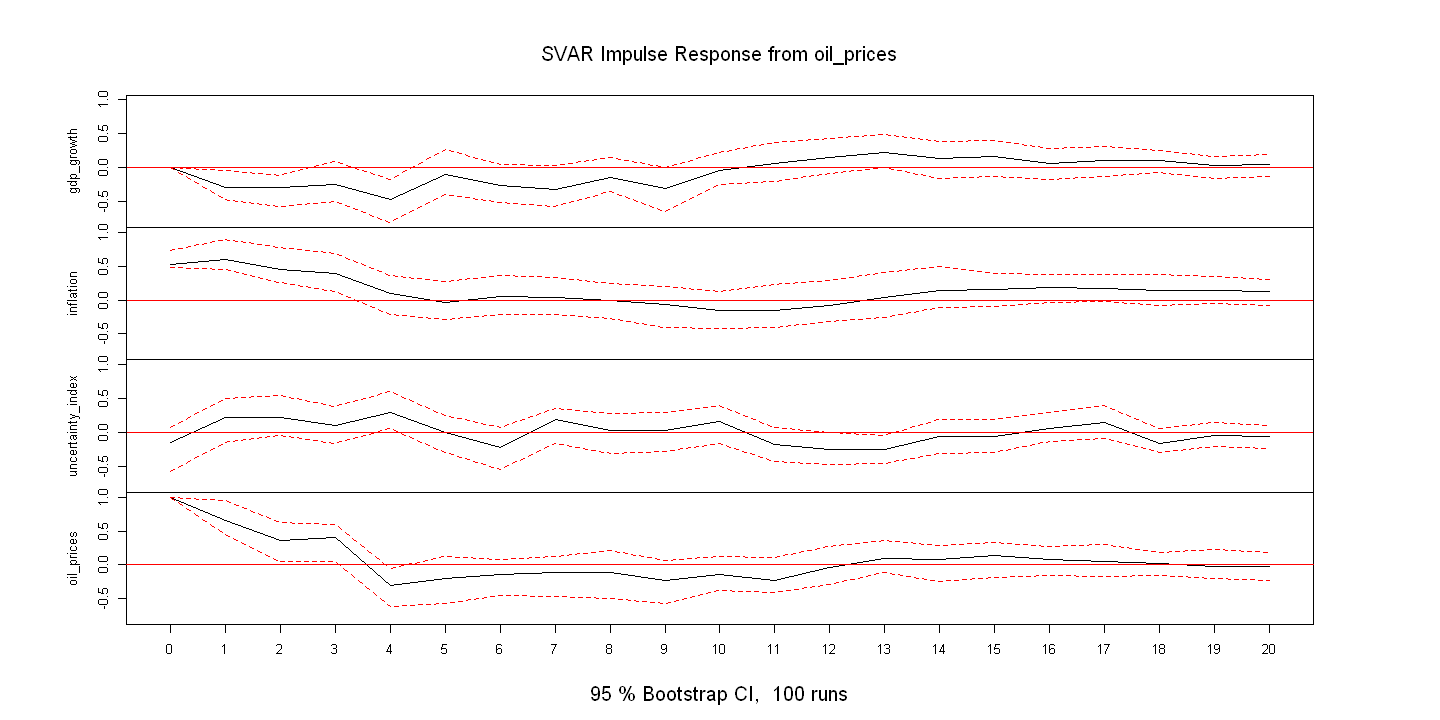

In [24]:
structVAR1 <-SVAR(var1, estmethod = "direct", Amat = NULL, Bmat = BMat, start = NULL, max.iter = 100, conv.crit = 1e-07, maxls = 1, lrtest = TRUE)
structVAR1_irf <- irf(structVAR1, n.ahead = 20, ci = 0.95, cumulative = F, boot = T)
plot(structVAR1_irf)

The results look very similar as in the case of Cholesky decomposition, so we will not spend time drawing any nieche conclusions. Instead, we will move on to

### 4) Estimation

We will use the `var1` model that we obtained in the previous section. The number of selected lags for this model is 9. Here are several plots that show the model's stability.

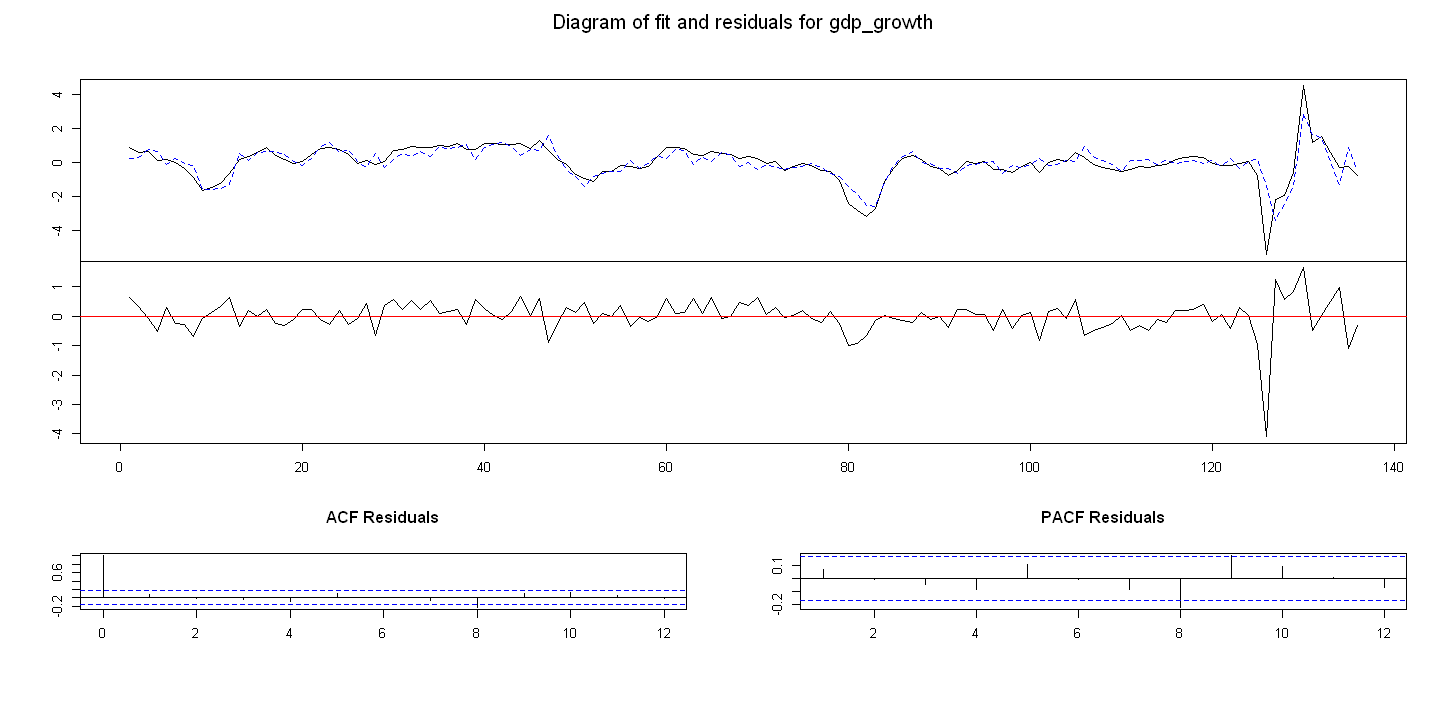

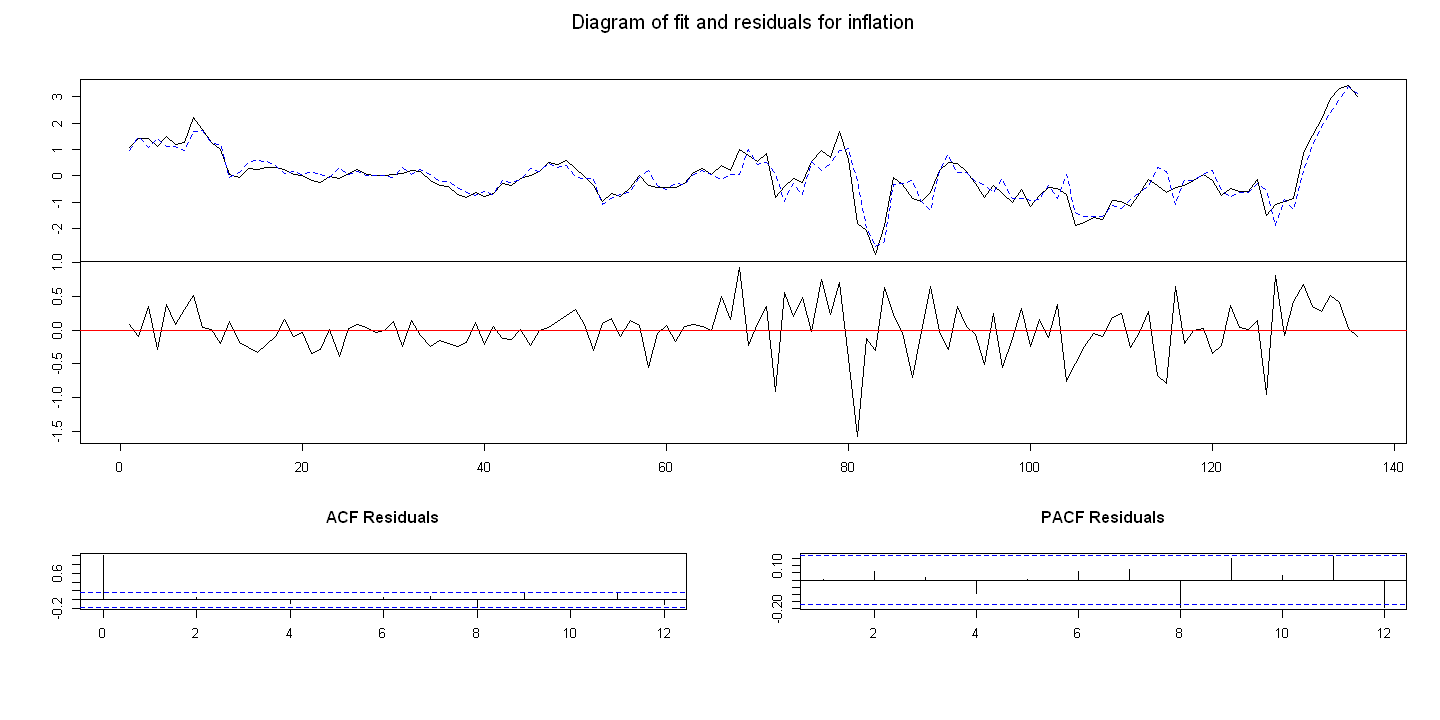

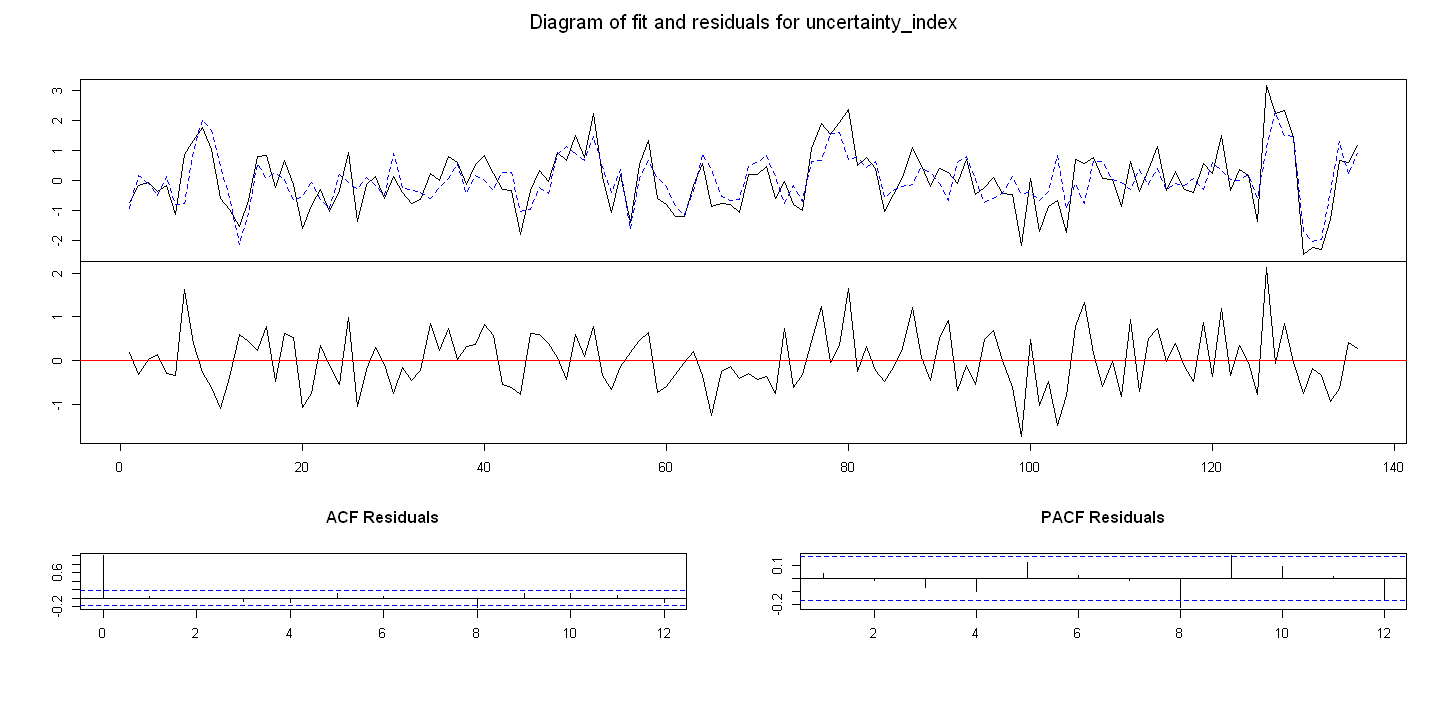

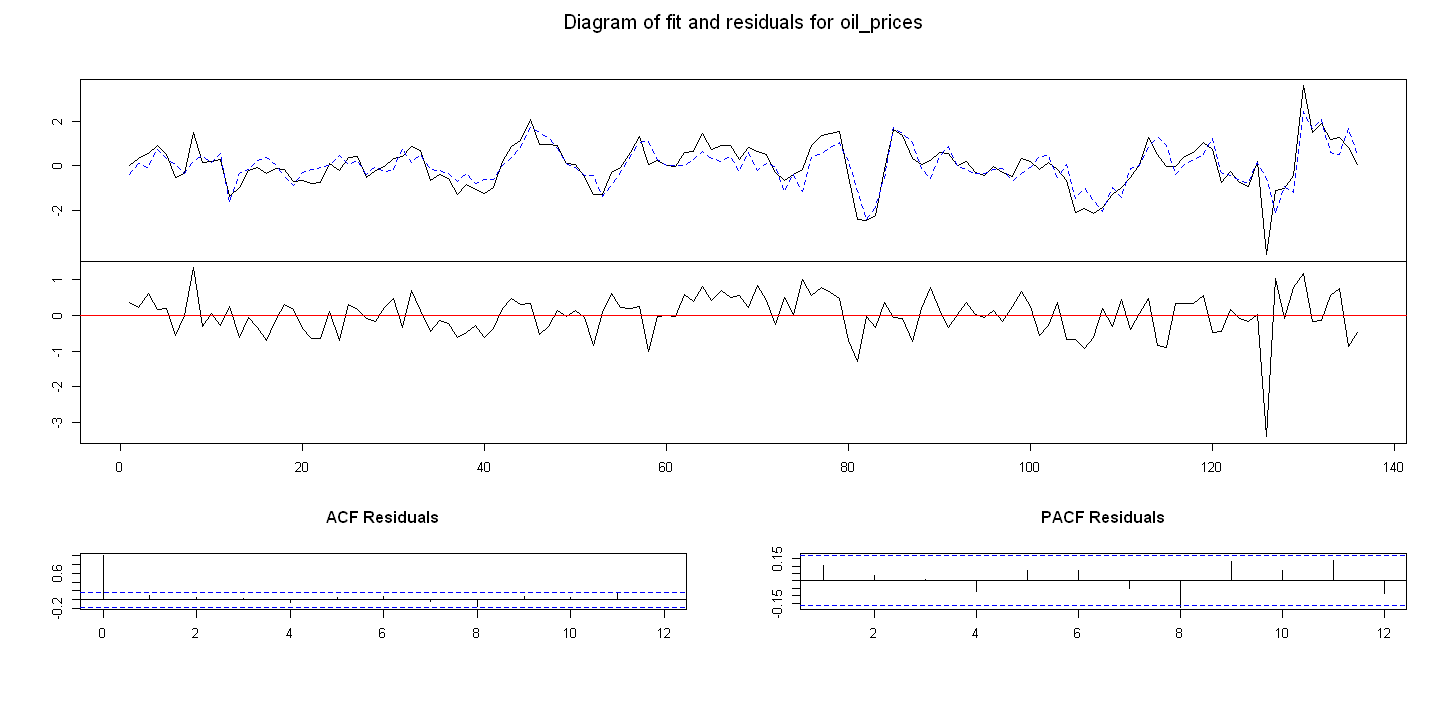

In [25]:
plot(var1)

All seems to be in order, the residuals are well behaved, and the series appear stable.

#### Alternative Strucural Identifications

As requested, I will now perform two alternative structural identifications to assess the robustness of the `var1` model. The two identifications that I chose are - *Cholesky Ordering*, and *Sign Restriction.*

##### Long-run Restriction

The first method is long-run restriction. The method involves testing for cointegration between the variables, which indicates the presence of a long-run equilibrium relationship, and imposing restrictions on the impulse response functions based on the estimated cointegration vectors. I chose the same specifications as before, again, to allow for direct comparability.

##### Sign Restriction

The second method, sign restriction, involves specifying a set of sign and magnitude restrictions that the impulse response functions must satisfy. The restrictions are then used to identify the structural shocks and estimate the impulse response functions. For the function, I will set the parameters quite arbitrarily.

Or so I would, if I managed to make the code run. I didn't manage to get the sign restrictions working, and after checking the setup, I realized this whole section is quite redundant as far as the output paper is concerned, so I will provide just one alternative, as I feel like that is totally enough, given the time-taken/merit-gained ratio is considered. I also considered recursive ordering, but it just feels redundant, just like this justification.

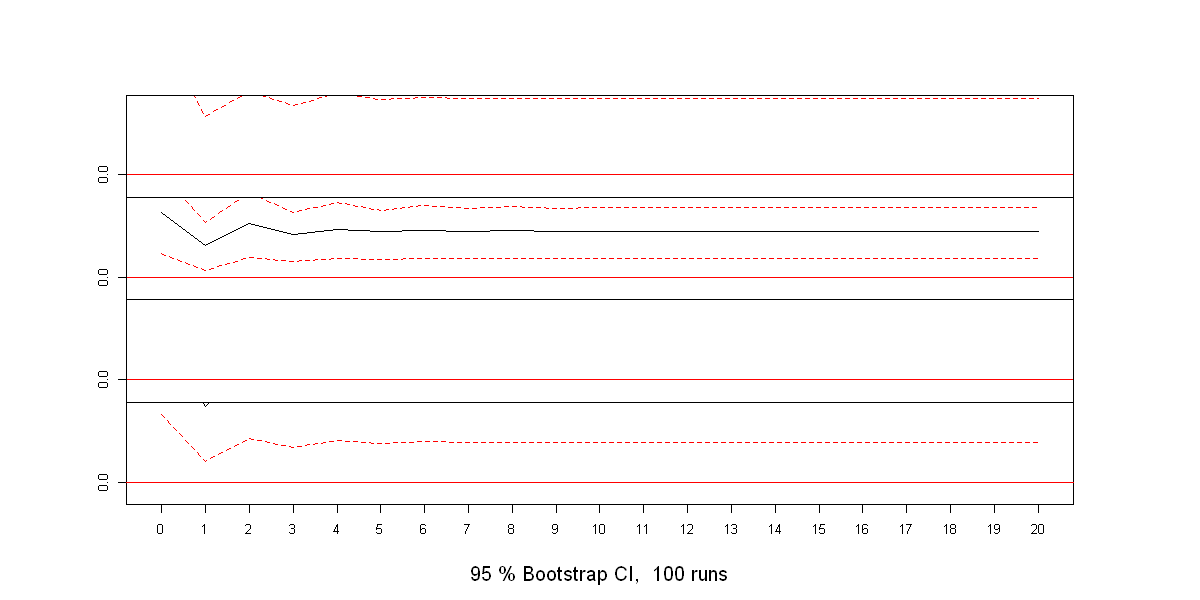

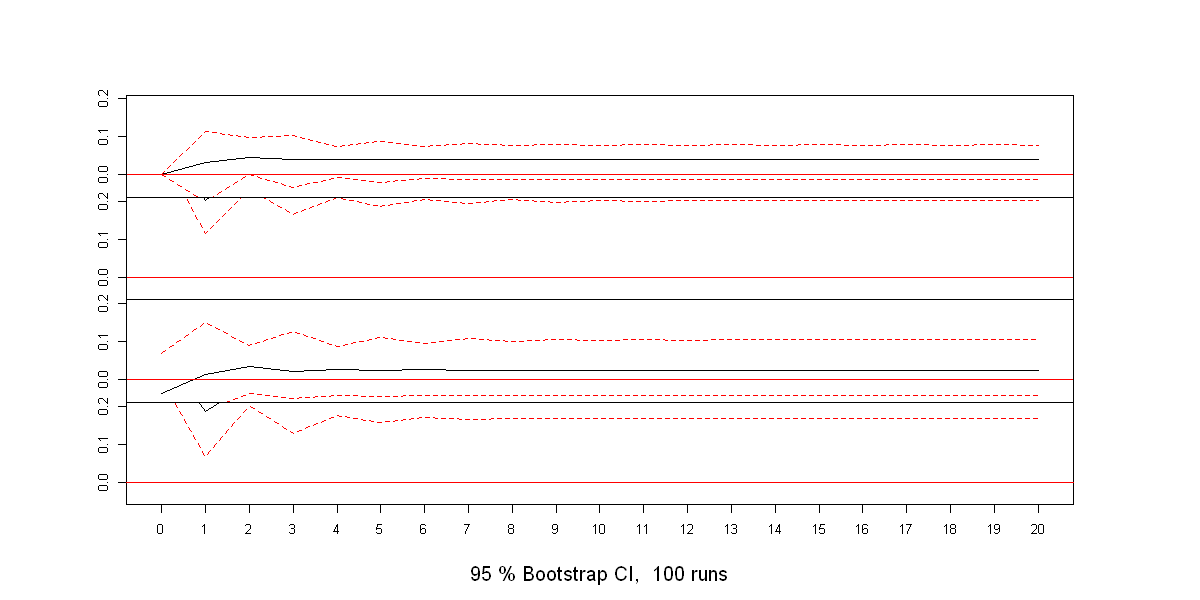

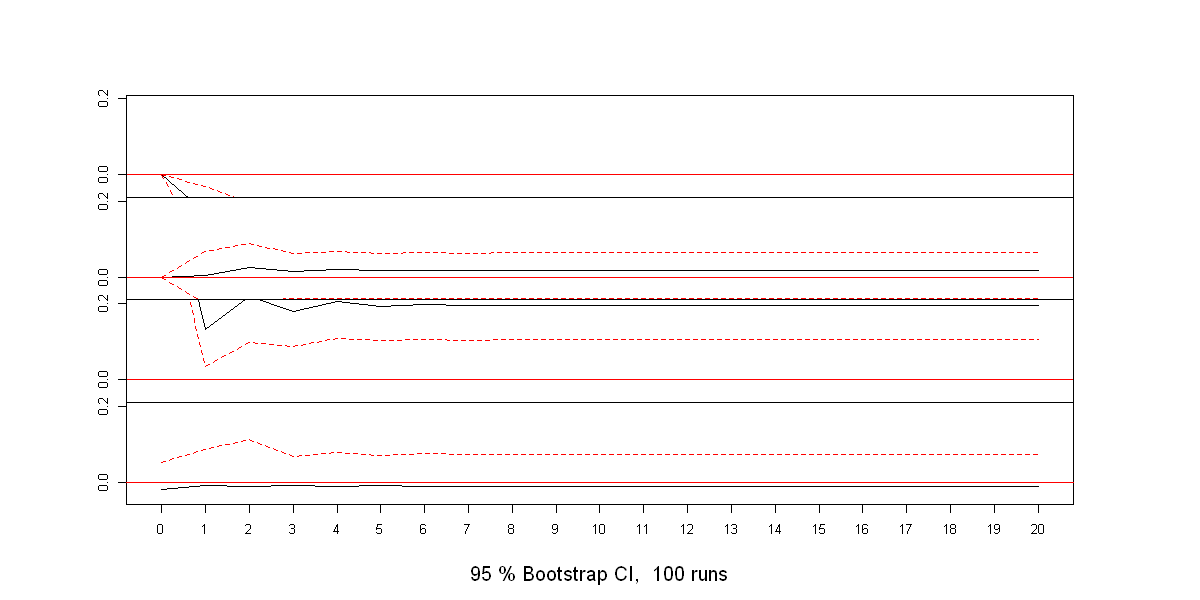

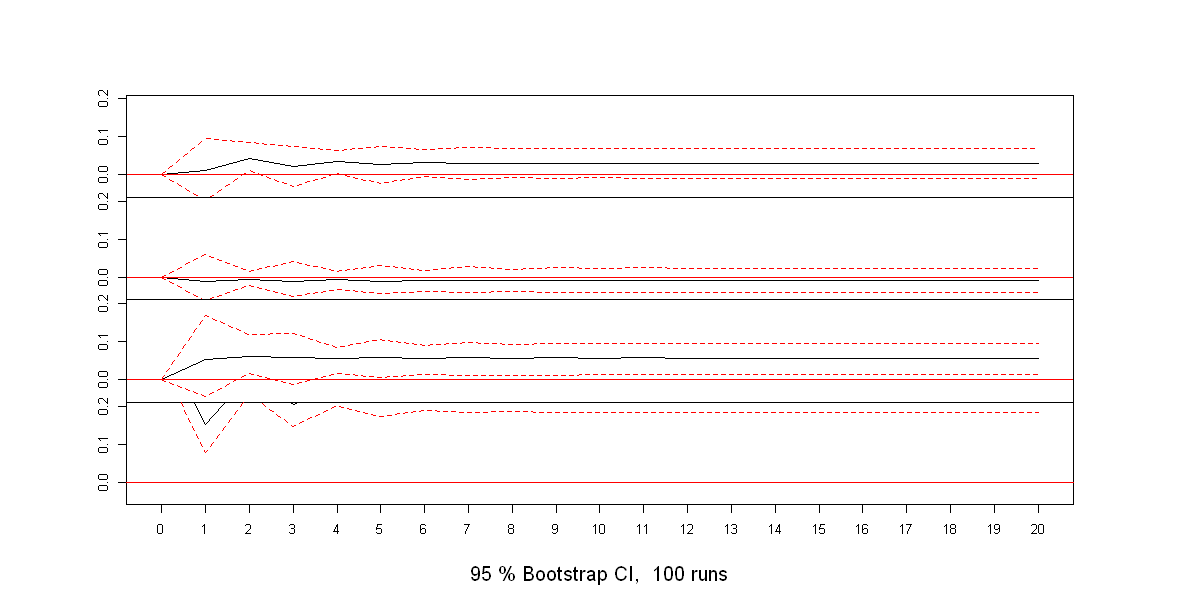

In [26]:
# Method 1: Long-run Restriction
var1_lr <- VAR(data_var, p = 9, type = "const")
var1_lr_res <- resid(var1_lr)
var1_lr_res_coint <- ca.jo(var1_lr_res, type = "trace", K = 2, spec = "transitory")
var1_lr_res_vecm <- vec2var(var1_lr_res_coint, r = 1)
var1_lr_res_irf <- irf(var1_lr_res_vecm, n.ahead=20, ortho=TRUE, boot=TRUE)
# Plot impulse response functions with shaded confidence intervals
options(repr.plot.width = 10, repr.plot.height = 5)
plot(var1_lr_res_irf, main = "", ylab = "", xlab = "Periods", ylim = c(-0.05, 0.2))

The results seem a bit off, quite frankly, but we suspect this is because of our code, rather than the data itself, and there is not enough reason to delve deep into analysis of the situation, so we will just assume this as a human mistake, and trust that the original VAR model specification is correct.

With that, we can move onto 

#### Forecasts

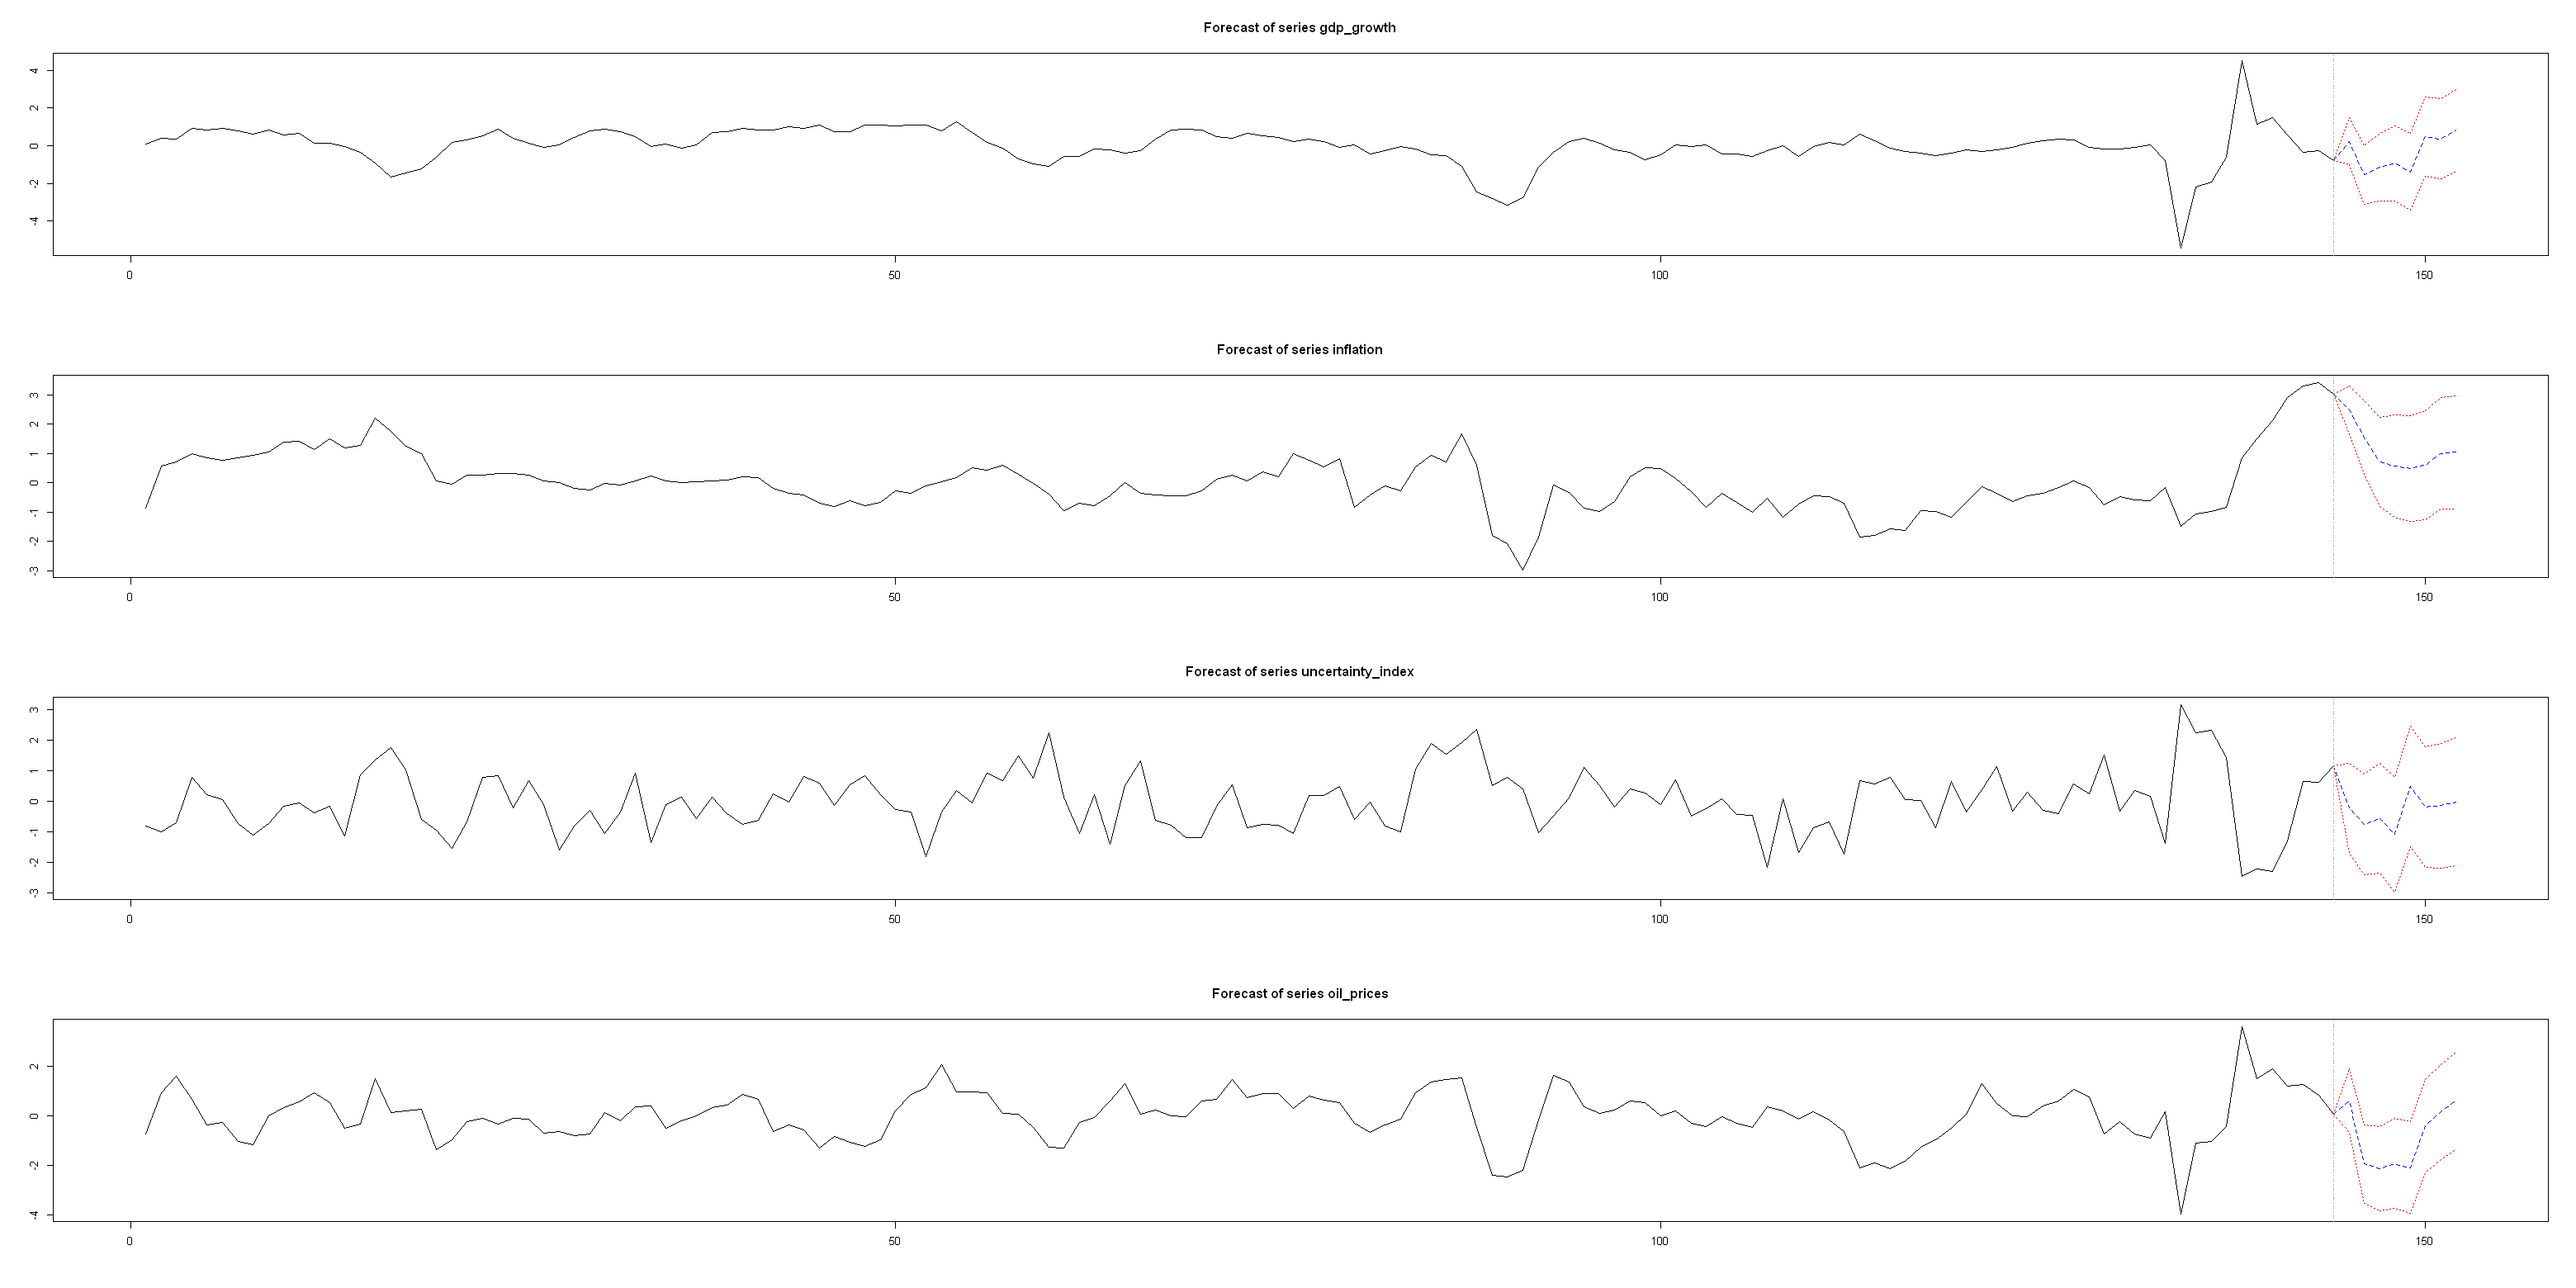

In [27]:
var_forecast <- predict(var1, n.ahead = 8, ci = 0.95)
options(repr.plot.width = 26, repr.plot.height = 13)
plot(var_forecast)

First of all, a comment about the results. They seem stable, depicting mostly mean-reverting behavior. Most of the confidence bands also appear quite narrow, which is a sign that the model is fairly confident when it comes to the predictions. It is difficult to say just from this simple forecast how much the volatility during the 2020 crisis affected the forecasts, we would have to dive in a bit deeper to claim anything with certainty.

We also provide the **forecast error variance decomposition**, as requested:

We could not get the legend to fit in the graph well, so here is a verbal description of what can be seen on the graph:
* Blue = GDP growth
* Red = Inflation
* Gray = Uncertainty Index
* Green = Oil prices

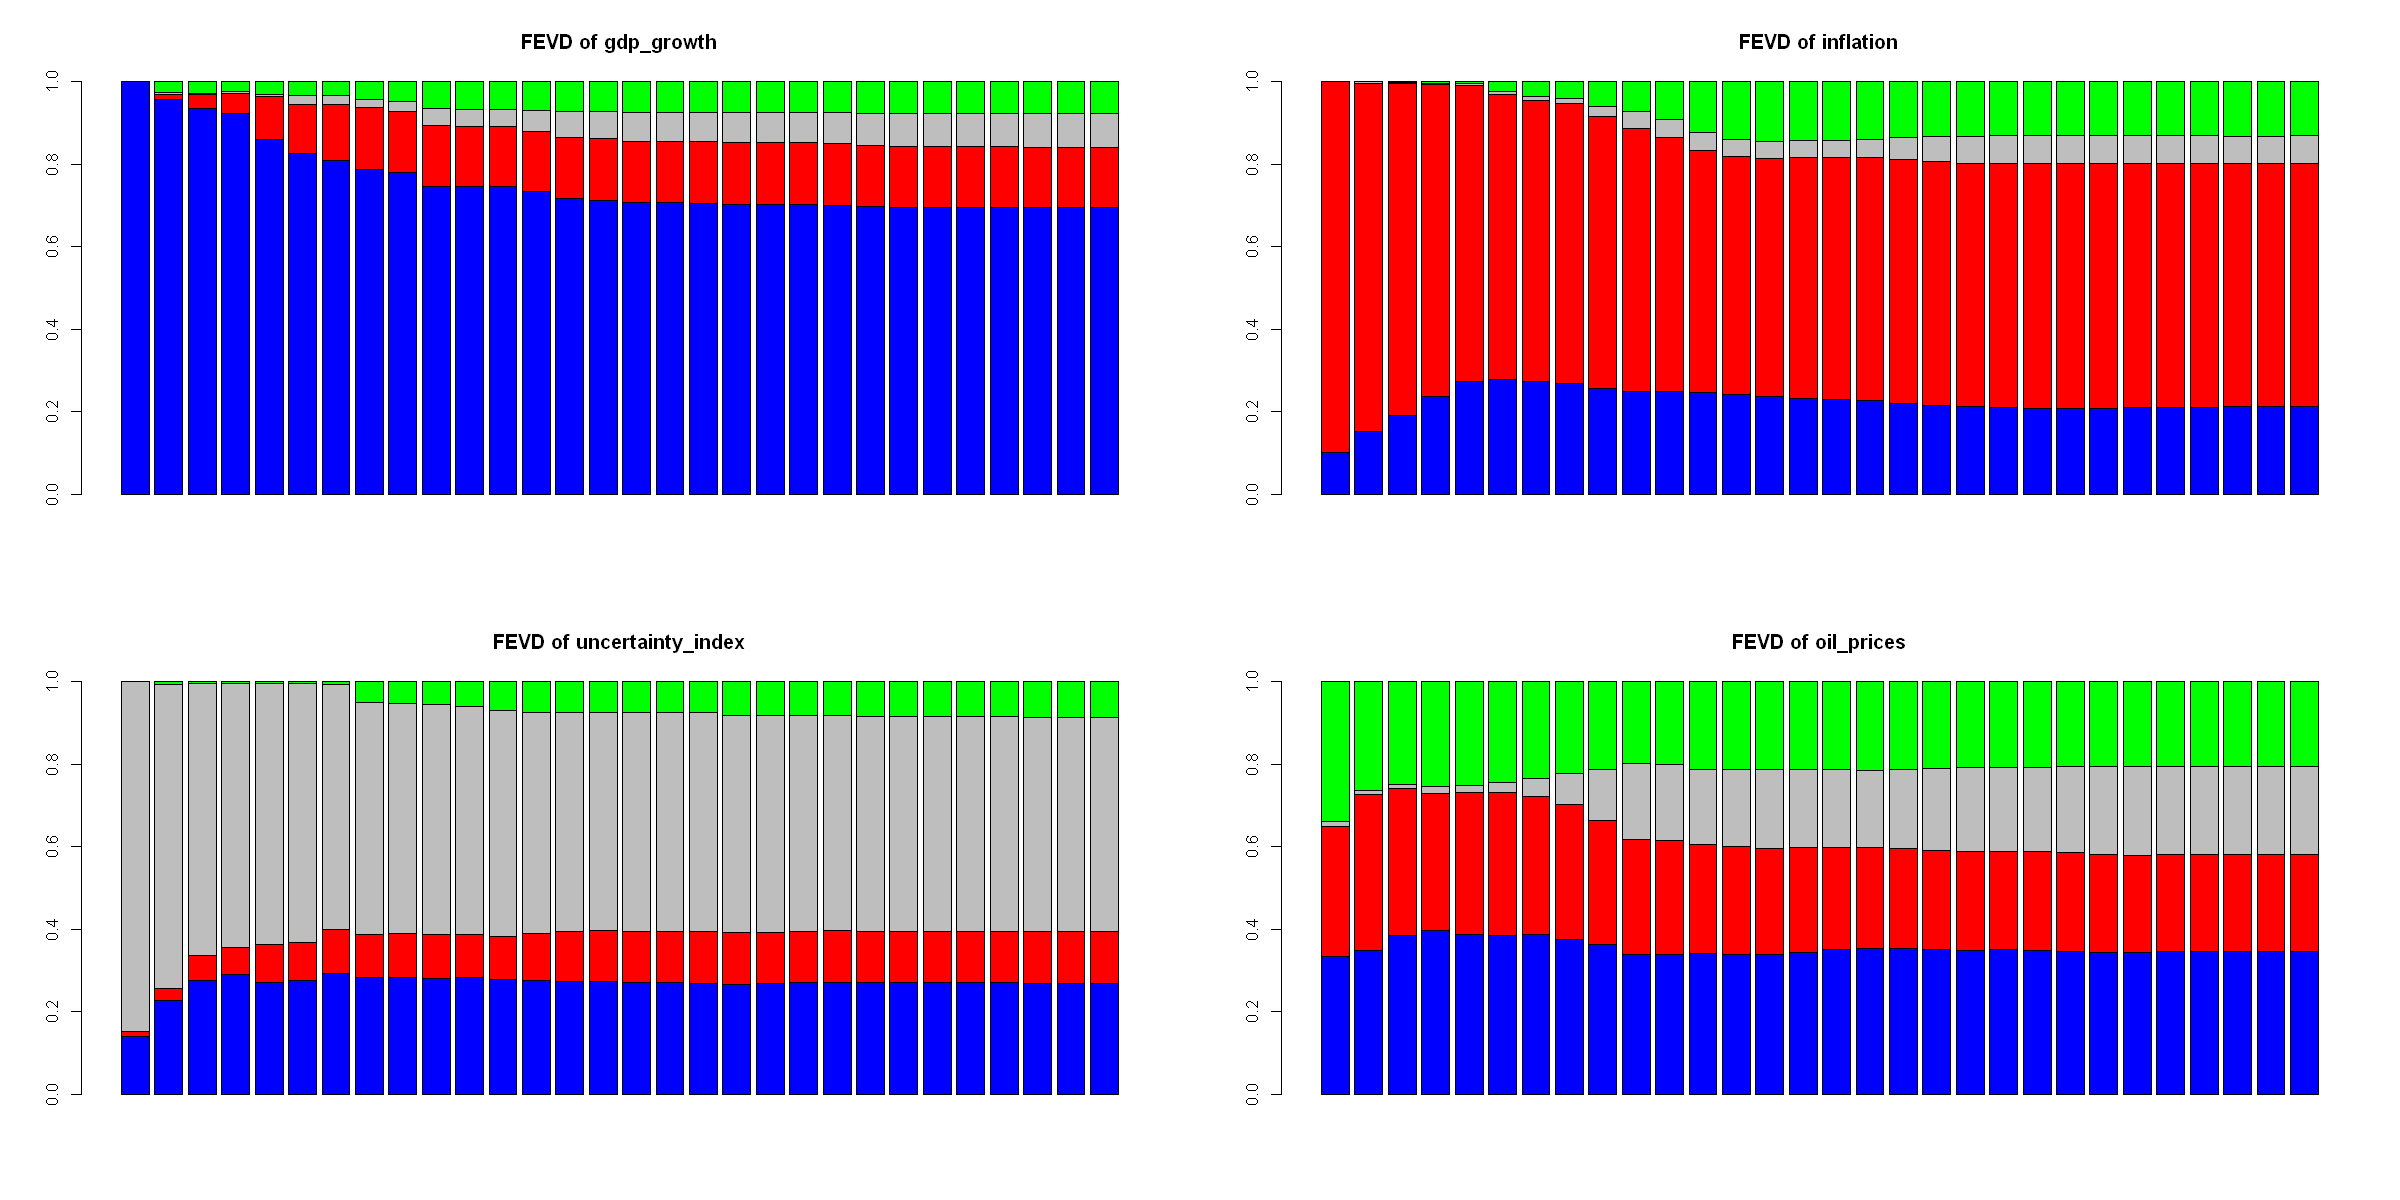

In [28]:
# Forecast Error Variance Decomposition
options(repr.plot.width = 20, repr.plot.height = 10)
par(mfrow =c(2,2))
var_cols <- colnames(data_var)
for (ii in 1:length(var_cols)){
  barplot(t(fevd(var1,n.ahead = 30)[[ii]]),
          col=c("blue","red","gray","green"),
          legend = NA, ann=F)
  title(main=paste("FEVD of",  var_cols[ii]))
}

It appears clear that the largest portion of the error is carried by the shock itself. Furthermore, the more endogenous the variable becomes, the larger portion of the uncertainty is carried by the other variables. Specifically, in the case of GDP growth, almost no uncertainty about the forecast stems from the other three variables, while in the case of Oil prices (the most endogenous of the four variables), the ratio is distributed much more evenly across time.

___

# 3rd Stage

## Analyze propagation of macroeconomic shocks: Checking result robustness

Before getting to the robustness check itself, we need to address the issue of data validity. After a seminar discussion, a suggestion has emerged proposing different data structure for the 3rd part. These proposed changes include:
* Adding an interest rate to the list of VAR variables
* Transforming the variables based on a *aggregate first, then take first differences* approach, contrary to the *difference right away with 4 times more lags* approach we chose in the previous section

As such, we will first be making the necessary data transformations, adding the interest rate data onto the third position (below inflation and above uncertainty index). This stems from the assumption that changes in inflation will motivate the central bank to policy adjustments, while the index and consequent market prices are but a (partial) product of the fiscal policy.

These **new data should serve us as a robustness check** against the 2nd part of the paper, and so we will apply the changes to this part and this part only, leaving the 2nd part as is.

With that said, let us move onto the data transformation itself.

In [29]:
# Fetching the interest rate data
fedfunds_data <- pdfetch_FRED("FEDFUNDS")
fedfunds_data <- ts_first_of_period(fedfunds_data) # First of period - monthly frequency
fedfunds_data_log <- log(fedfunds_data) # To log
fedfunds_data_seas <- handleSeasonality(fedfunds_data_log, "fedfunds") # Adjust for seasonality

# Data to transform to quarterly frequency, take first differences on, and append to GDP
to_quarterly_data <- list(cpi_log, fedfunds_data_seas, uncertainty_index_data_seas, oil_data_seas)

# To quarterly data
quarterly_data <- lapply(to_quarterly_data, function(x){
    to.period(x, period = "quarter", OHLC = FALSE)
})

# First of the period
quarterly_data <- lapply(quarterly_data, function(x){
    ts_first_of_period(x)
})

# First differences
fd_data <- lapply(quarterly_data, function(x){
    100*diff(x, 1)
})

# Drop missing observations
clean_data <- lapply(fd_data, function(x){
    na.omit(x)
})

# Basis for the new data frame will be GDP data only
data_var_orig_3rd_part <- data_var_orig$gdp_growth[data_var_index]

# Append the rest of the data in order
data_var_orig_3rd_part$inflation <- clean_data[[1]][data_var_index] # Inflation data
data_var_orig_3rd_part$fedfunds <- clean_data[[2]][data_var_index] # Interest rate data
data_var_orig_3rd_part$uncertainty_index <- clean_data[[3]][data_var_index] # Uncertainty index data
data_var_orig_3rd_part$oil_prices <- clean_data[[4]][data_var_index] # Oil data

# Scale the data
data_var_scaled <- apply(data_var_orig_3rd_part, MARGIN = 2, scale)

# Back to an .xts object
data_var_3rd <- as.xts(data_var_scaled, order.by = index(data_var_orig_3rd_part)) # Differenced, 5 variables

# Print out the result into the console
print(data_var_3rd)

             gdp_growth    inflation     fedfunds uncertainty_index
1987-01-01   0.10250450   0.88238004  -0.30863821        0.45609156
1987-04-01   0.40455040   0.72088548   0.25776609       -0.03736044
1987-07-01   0.36163448   0.56464513   0.19638234       -1.74723723
1987-10-01   0.92674945   0.14371831  -0.16137137        2.18889730
1988-01-01   0.81684937   0.13427285  -0.06600968       -1.04103849
1988-04-01   0.92933819   0.91933157   0.36092094       -0.64540589
1988-07-01   0.79392964   0.89414932   0.23995739        0.20432915
1988-10-01   0.61050254   0.48276920   0.18841647        0.20788509
1989-01-01   0.85077479   0.85038886   0.32126121       -0.10764302
1989-04-01   0.58685247   1.32997990  -0.07812773       -0.10702215
       ...                                                         
2020-07-01 -2.185433464  0.760108654  0.322609719      -0.245501094
2020-10-01 -1.935284454  0.123303074  0.009632168       0.486282622
2021-01-01 -0.621365971  0.628530077 -0.65817006

### 1) VAR in levels

The data transformation we have just done will come in handy later on in the task. Meanwhile, we now have to do a similar transformation on the non-logarithmized series to be able to estimate VAR in levels.

For this, we will make use of the `quarterly_data` object from the previous code block, which is a **list containing quarterly, logarithmized, seasonally adjusted data for all series but GDP**. We will combine this list of data with the log of seasonally adjsuted GDP data to obtain the data frame for the VAR in levels - `data_var_levels`.

In [30]:
# First get the data that needed to be transformed to quarterly frequency (all but GDP)
data_var_levels_quarterly <- lapply(quarterly_data, na.omit) 

# Then get the log gdp data
data_var_levels <- gdp_log[data_var_index]

# Append the rest of the data in order
data_var_levels$inflation <- data_var_levels_quarterly[[1]][data_var_index] # Inflation data
data_var_levels$fedfunds <- data_var_levels_quarterly[[2]][data_var_index] # Interest rate data
data_var_levels$uncertainty_index <- data_var_levels_quarterly[[3]][data_var_index] # Uncertainty index data
data_var_levels$oil_prices <- data_var_levels_quarterly[[4]][data_var_index] # Oil data

# Rename columns
colnames(data_var_levels) <- c(
    "real_gdp_log",
    "prices_log",
    "fedfunds_log",
    "uncty_index_log",
    "oil_prices_log"
)

# Print out the result into the console
print(data_var_levels)

           real_gdp_log prices_log fedfunds_log uncty_index_log oil_prices_log
1987-01-01     9.033039   4.720283     1.813195        4.804716       2.906901
1987-04-01     9.043770   4.731803     1.906575        4.797095       2.999226
1987-07-01     9.052408   4.742320     1.976855        4.369212       2.971952
1987-10-01     9.069433   4.750136     1.912501        4.908770       2.849550
1988-01-01     9.074586   4.757891     1.884035        4.654460       2.785011
1988-04-01     9.087639   4.770685     2.016235        4.497390       2.805177
1988-07-01     9.093481   4.783316     2.102914        4.549172       2.676903
1988-10-01     9.106718   4.793308     2.170196        4.601828       2.796061
1989-01-01     9.116833   4.805659     2.287471        4.576932       2.969388
1989-04-01     9.124437   4.821088     2.254445        4.552189       2.998229
       ...                                                                    
2020-07-01    9.8386140  5.5607932   -2.4079456     

In [31]:
# Selectign the optimal number of lags
var2.select <- VARselect(data_var_levels, lag.max=10, type="const")
print(var2.select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
     2      2      1      2 


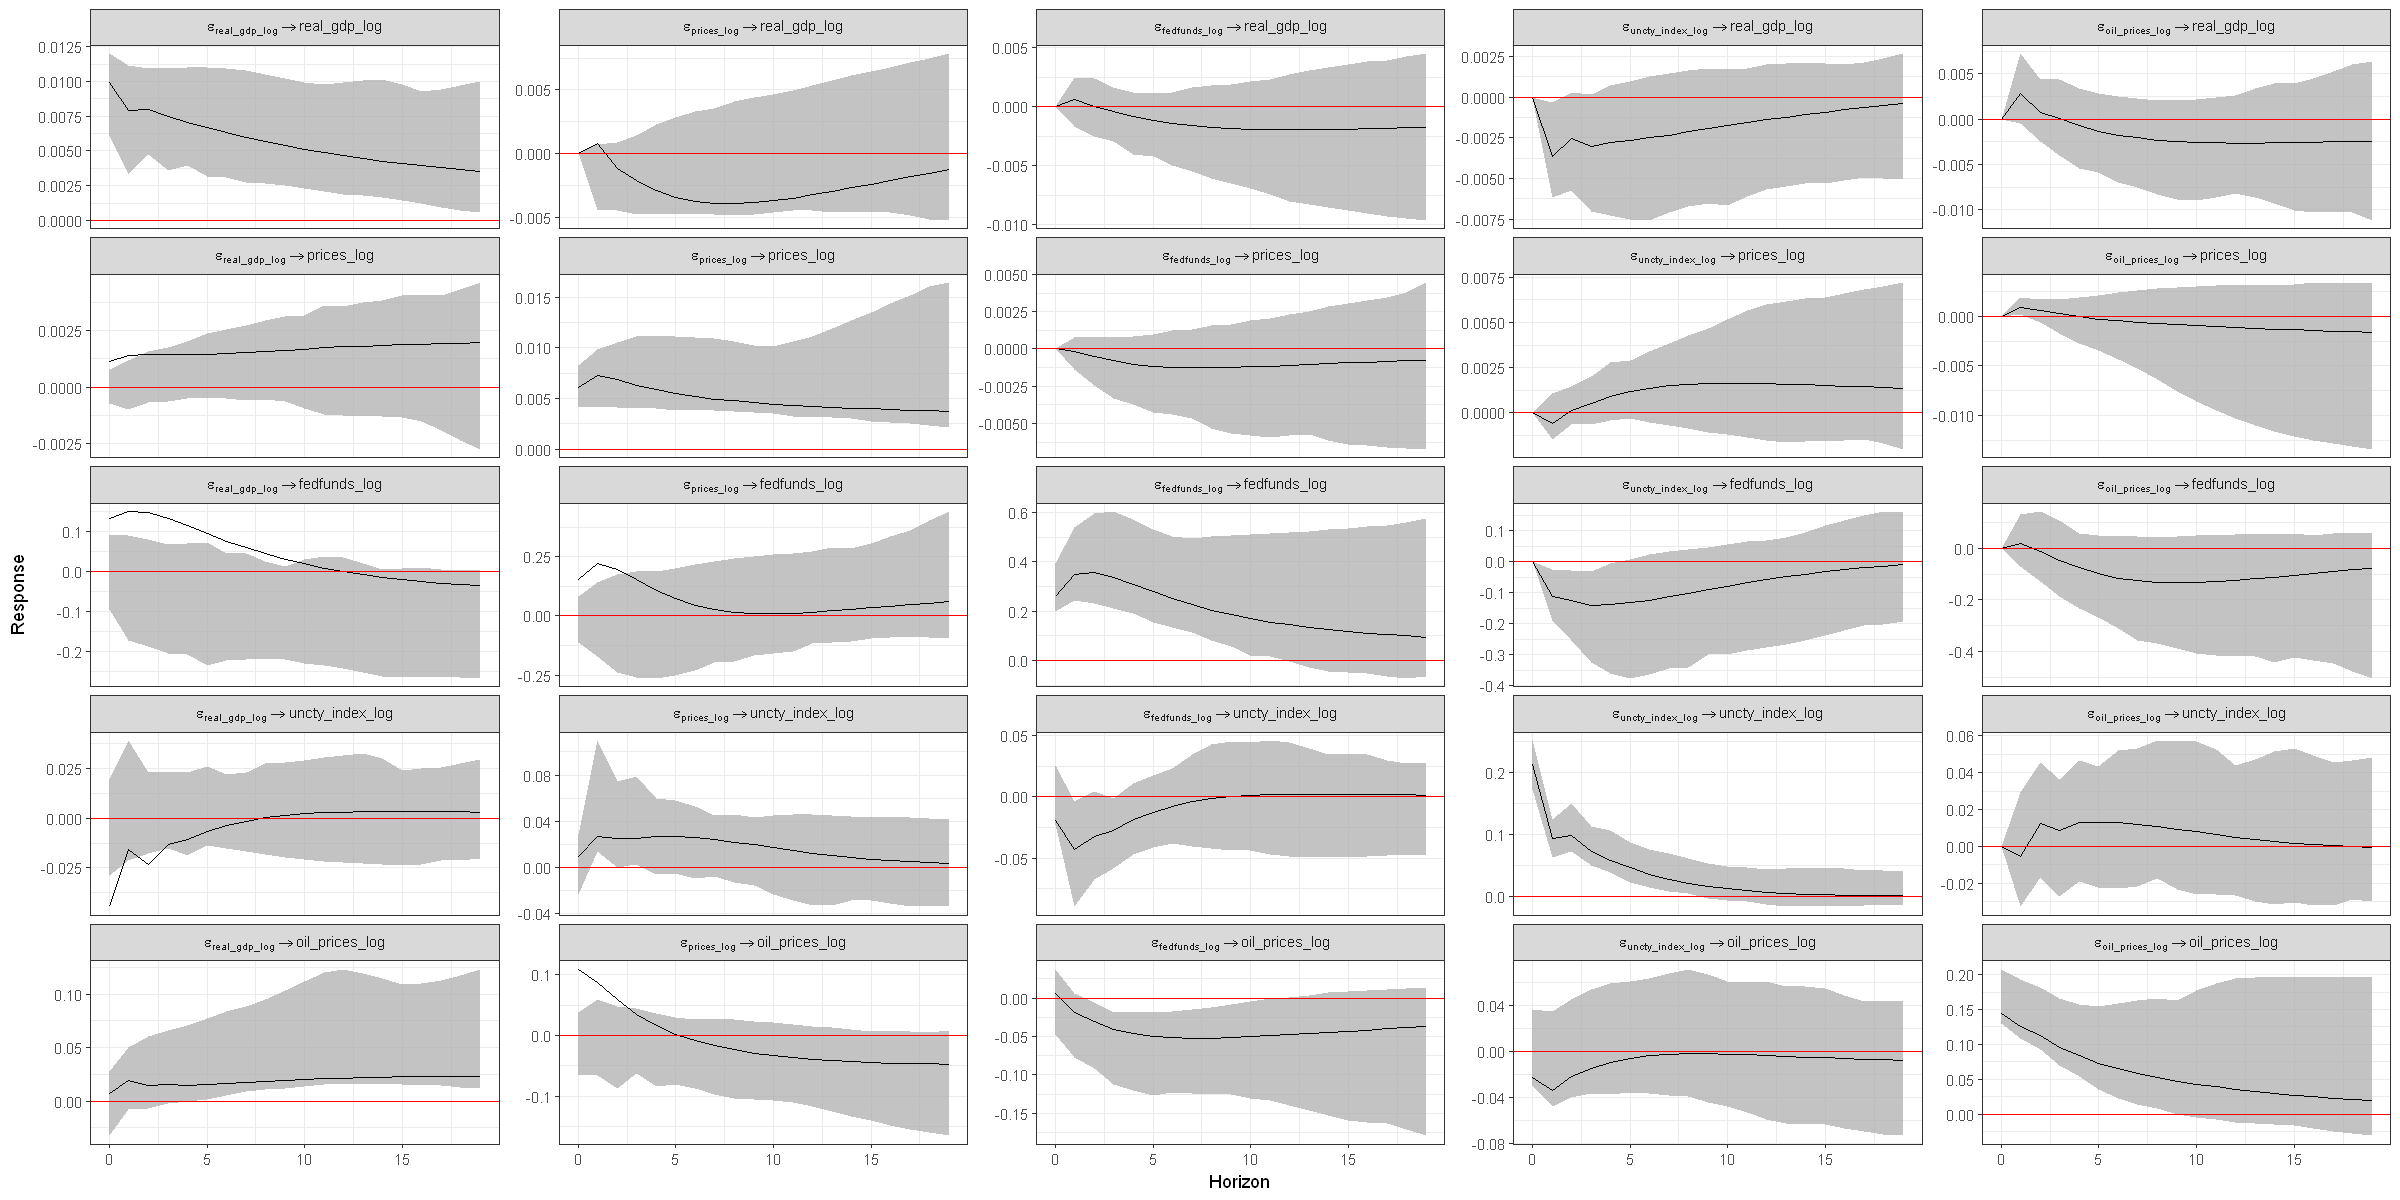

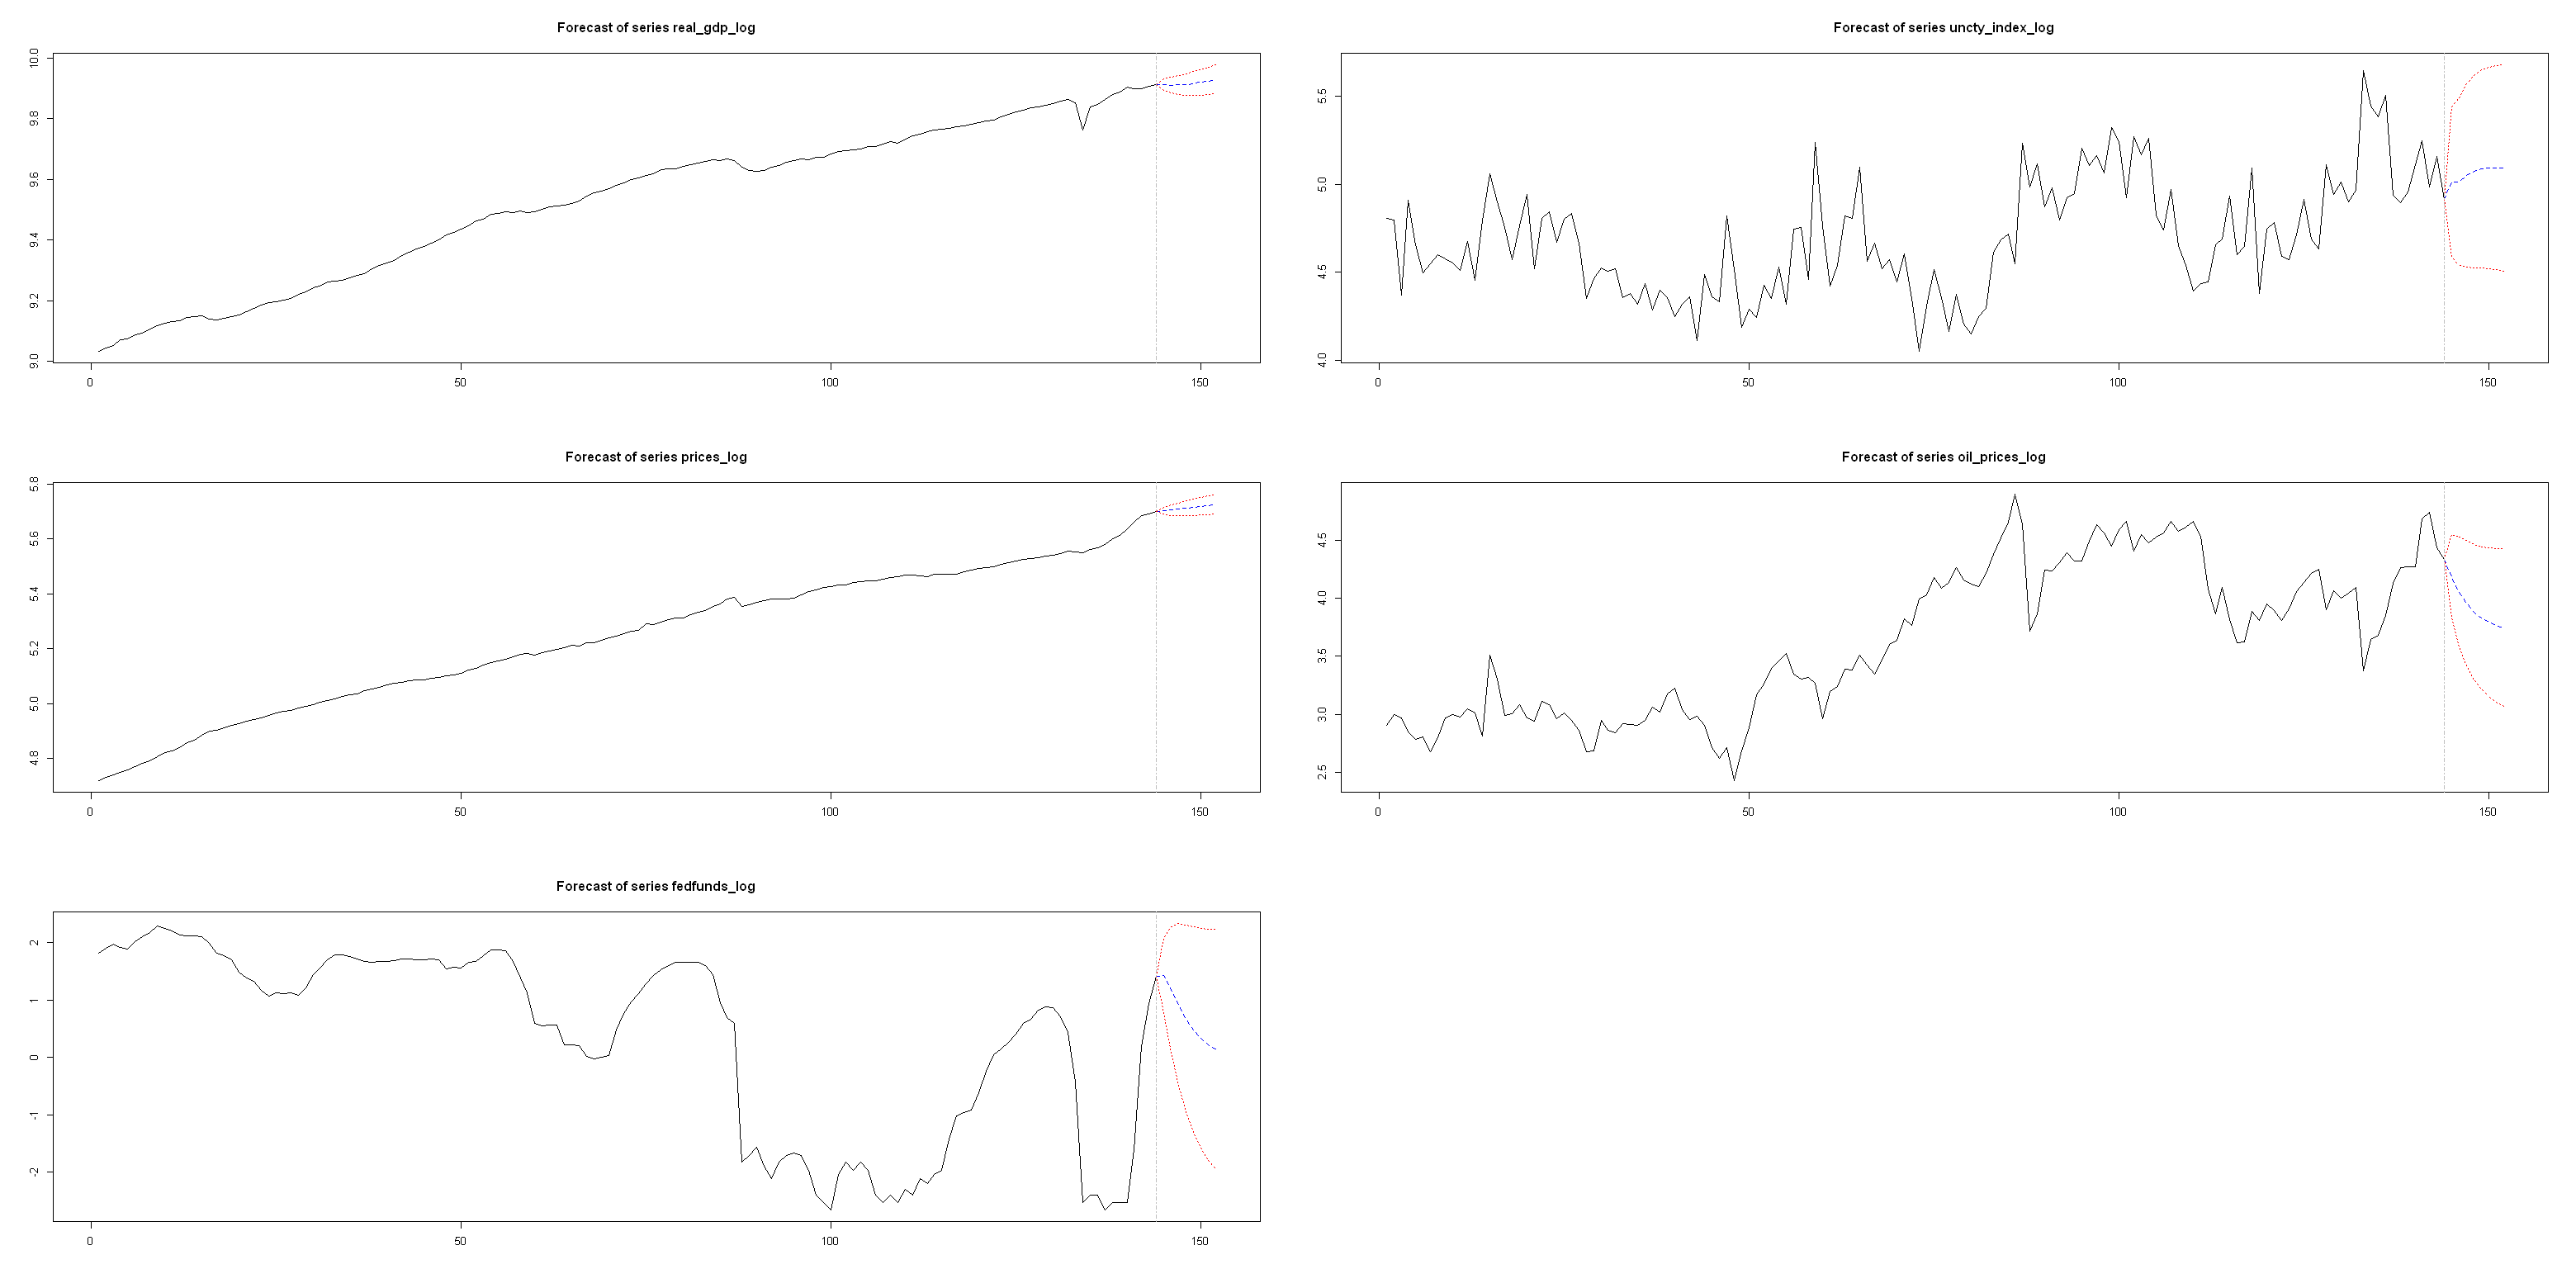

In [32]:
# We run the vector autoregression using the suggested number of lags.
var2 <- VAR(data_var_levels, p=2, type="const")

# Cholesky and IRF
var2_cholesky <- id.chol(var2)
var2_cholesky_svarsirf <- irf(var2_cholesky, n.ahead = 20)
var2_bootirf <- wild.boot(var2_cholesky, design = "fixed", distr = "gaussian", n.ahead = 20, nboot = 100)
plot(var2_bootirf, lowerq = 0.05, upperq = 0.95)

# Forecasts
var_forecast <- predict(var2, n.ahead = 8, ci = 0.95)
options(repr.plot.width = 26, repr.plot.height = 13)
plot(var_forecast)


Right away, we can see that the number of suggested lags is significantly lower - 2 instead of 8. When it comes to impulse response functions, most of the responses are as expected. **Shock in GDP and in the uncertainty causes price growth**, although in the latter case the response is positive and statistically significant only for but a single period across all observed periods. The response virtually disappears right after this.

**Shock in the uncertainty index leads to a negative GDP growth**, which is also a good sign and is in line with macroeconomic theory.

Predictions for GDP and prices are very stable, as opposed to the wide confidence intervals of the remaining 3 series. Most interestingly, the forecast for oil prices appears anything but positive, despite the series having a possible long-term growth trend. Otherwise, no surprising forecasts are present.

### 2) Vector Error Correction Model

We will first run the Johansen procedure with the levels data. These are stored under the variable `data_var_levels`.

In [33]:
# Johansen procedure
coint_var2 <- ca.jo(data_var_levels, type = "eigen", ecdet = "const", K = 2)
summary(coint_var2)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , without linear trend and constant in cointegration 

Eigenvalues (lambda):
[1]  0.4710777995475260437885  0.2085717364400953566239
[3]  0.1125652526854324236849  0.0511455229946876574476
[5]  0.0128828959553322335702 -0.0000000000000007452391

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 4 |  1.84  7.52  9.24 12.97
r <= 3 |  7.45 13.75 15.67 20.20
r <= 2 | 16.96 19.77 22.00 26.81
r <= 1 | 33.22 25.56 28.14 33.24
r = 0  | 90.44 31.66 34.40 39.79

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                   real_gdp_log.l2 prices_log.l2 fedfunds_log.l2
real_gdp_log.l2          1.0000000     1.0000000      1.00000000
prices_log.l2          -27.0423570    -1.4644170     -0.95963426
fedfunds_log.l2          2.3345661     0.1084930     -0.05152909
uncty_index_log.l2      17.9931

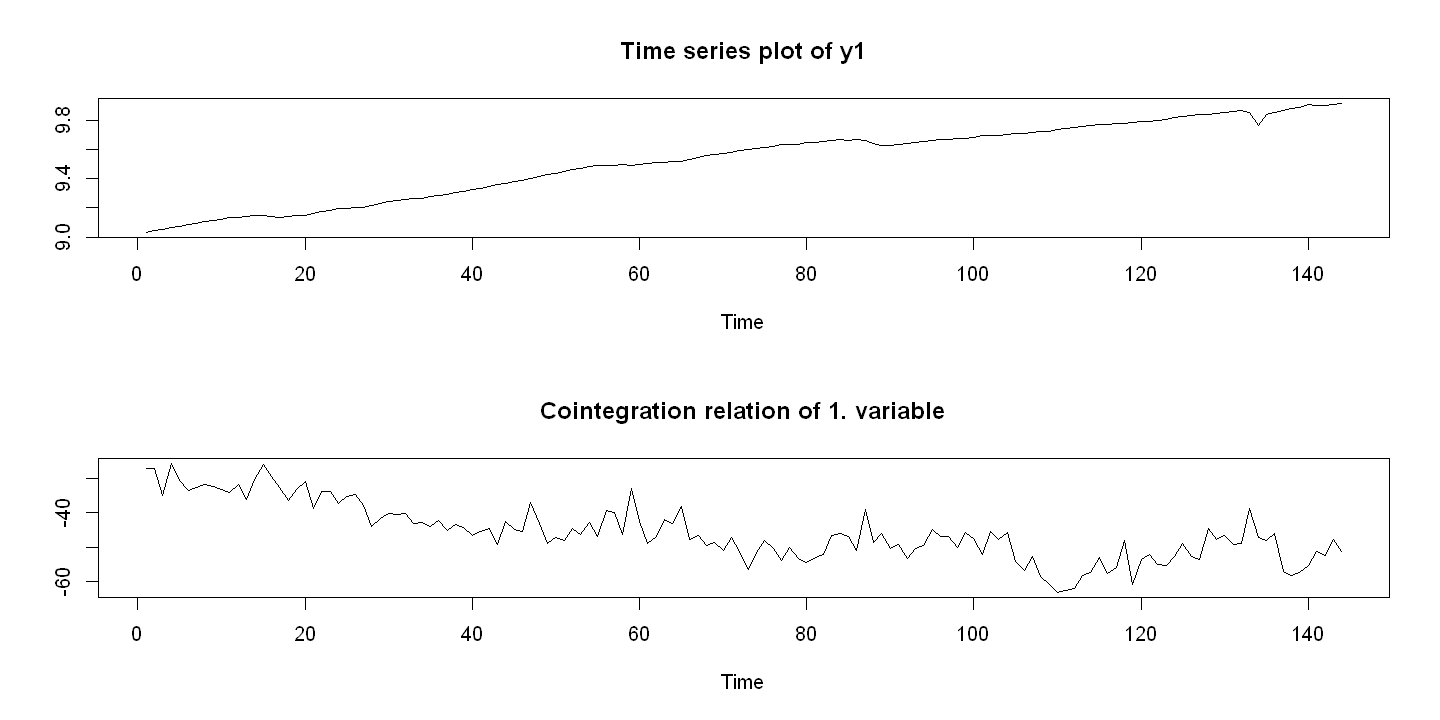

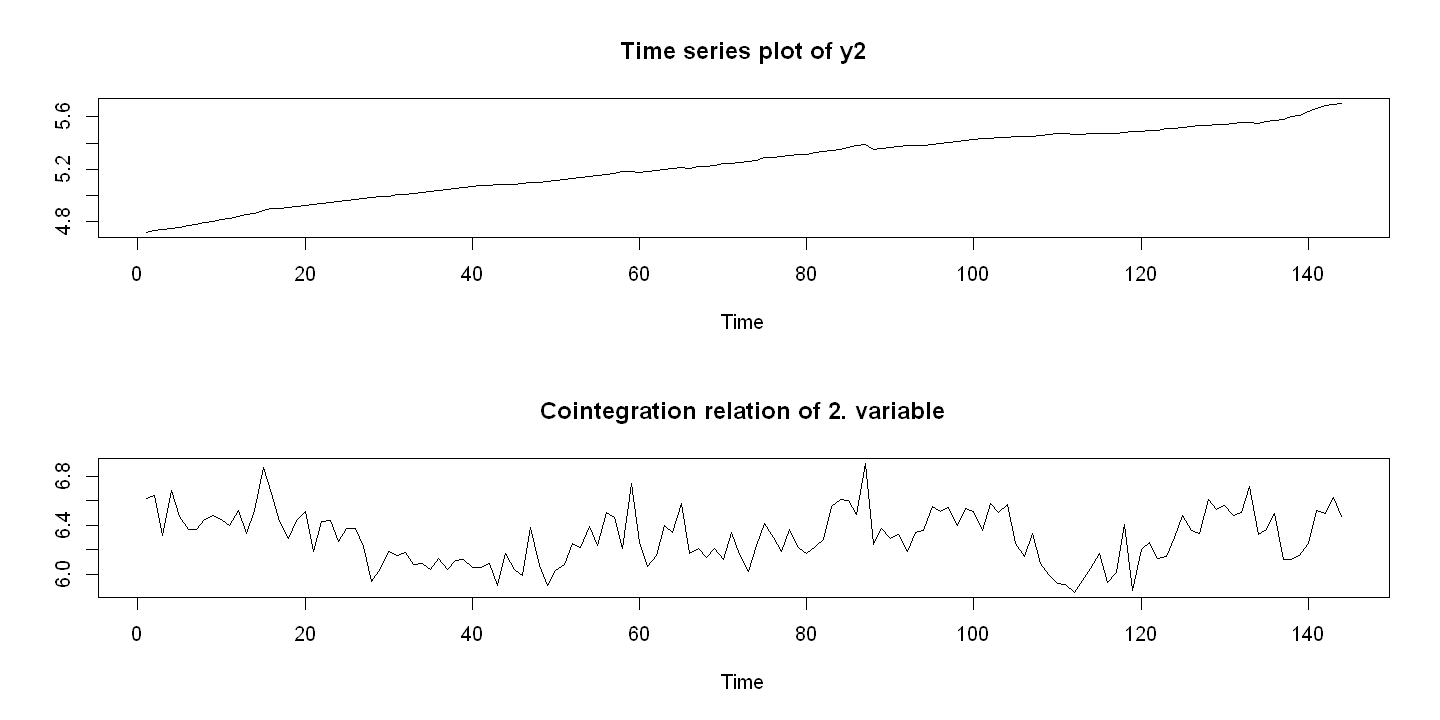

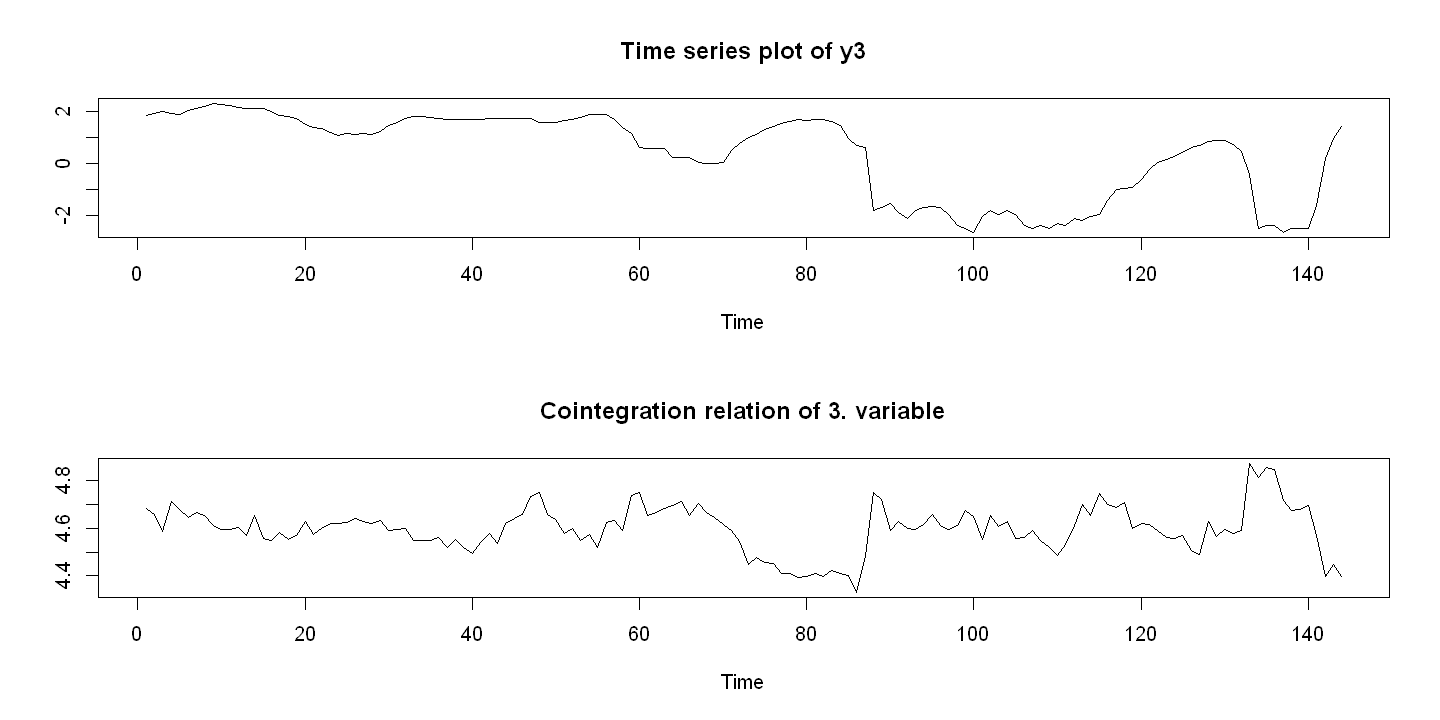

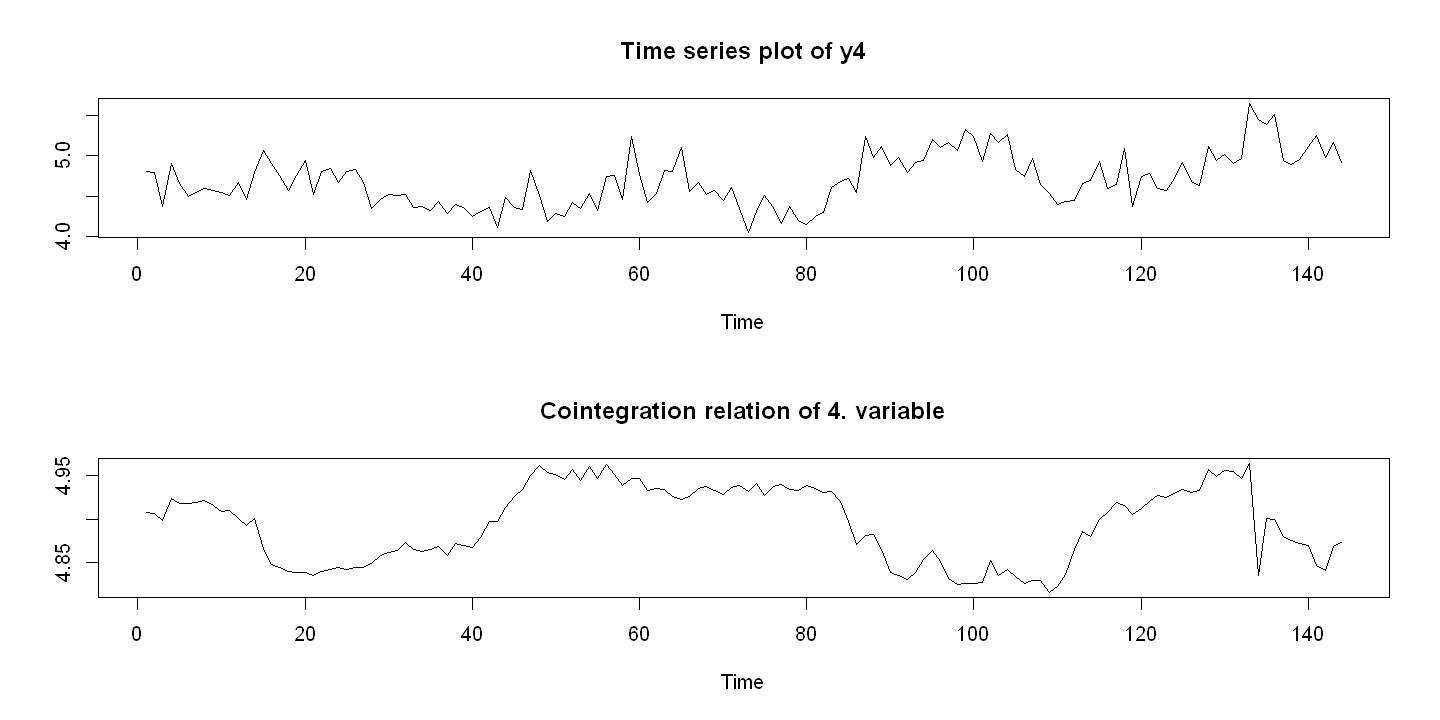

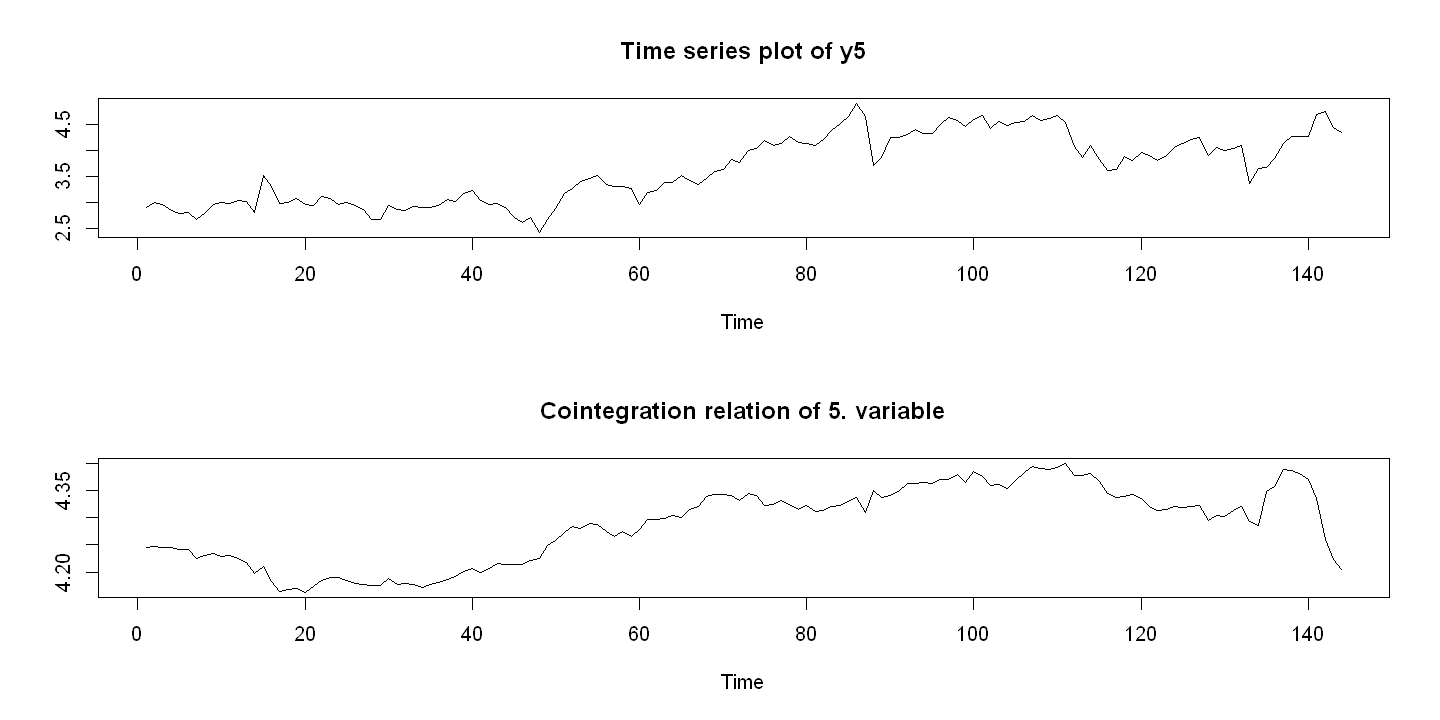

In [34]:
options(repr.plot.width = 12, repr.plot.height = 6)
plot(coint_var2)

Based on the Johansen procedure, we can claim with near certainty that there are 2 cointegration vectors in our data. Possibly, one could claim the presence of but one vector, as the $r<=1$ hypothesis gets rejected at 1% significance level given the test statistic 33.22, but given that the test statistic for $r<=2$ is enough to reject all 3 significance levels, **we assume the presence of no more than 2 cointegration vectors in our data**.

With this information, we move onto the VECM estimation.

In [35]:
# VECM estimation
cajorls_var2 <- cajorls(coint_var2, r=2) # Using OLS regression
summary(cajorls_var2$rlm)

vecm_var2 <- vec2var(coint_var2, r=2) # VECM to VAR in levels
summary(vecm_var2)

Response real_gdp_log.d :

Call:
lm(formula = real_gdp_log.d ~ ect1 + ect2 + real_gdp_log.dl1 + 
    prices_log.dl1 + fedfunds_log.dl1 + uncty_index_log.dl1 + 
    oil_prices_log.dl1 - 1, data = data.mat)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.070463 -0.003991  0.000832  0.004423  0.040578 

Coefficients:
                     Estimate Std. Error t value  Pr(>|t|)    
ect1                -0.018101   0.004764  -3.800  0.000218 ***
ect2                 0.019842   0.007067   2.808  0.005731 ** 
real_gdp_log.dl1    -0.260325   0.085413  -3.048  0.002774 ** 
prices_log.dl1      -0.248625   0.188006  -1.322  0.188261    
fedfunds_log.dl1     0.000732   0.002995   0.244  0.807292    
uncty_index_log.dl1 -0.016111   0.003758  -4.287 0.0000342 ***
oil_prices_log.dl1   0.020831   0.005628   3.701  0.000311 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009862 on 135 degrees of freedom
Multiple R-squared:  0.4572,	Adjus

              Length Class  Mode   
deterministic    5   -none- numeric
A                2   -none- list   
p                1   -none- numeric
K                1   -none- numeric
y              720   -none- numeric
obs              1   -none- numeric
totobs           1   -none- numeric
call             3   -none- call   
vecm             1   ca.jo  S4     
datamat       2272   -none- numeric
resid          710   -none- numeric
r                1   -none- numeric

From what we can see from the VECM estimation, the two cointegration vectors, *ect1* and *ect2*, are both significant. This indicates that **there is a long-run relationship between real GDP, prices, federal funds, unemployment index, and oil prices**.

In the short-run dynamics, the lagged values of GDP, uncertainty index, and oil prices are statistically significant too. This suggests that the **growth in real GDP is influenced by its own lagged growth, the lagged change in the unemployment index, and the lagged change in oil prices**.

Let us observe the **impulse response functions** now.

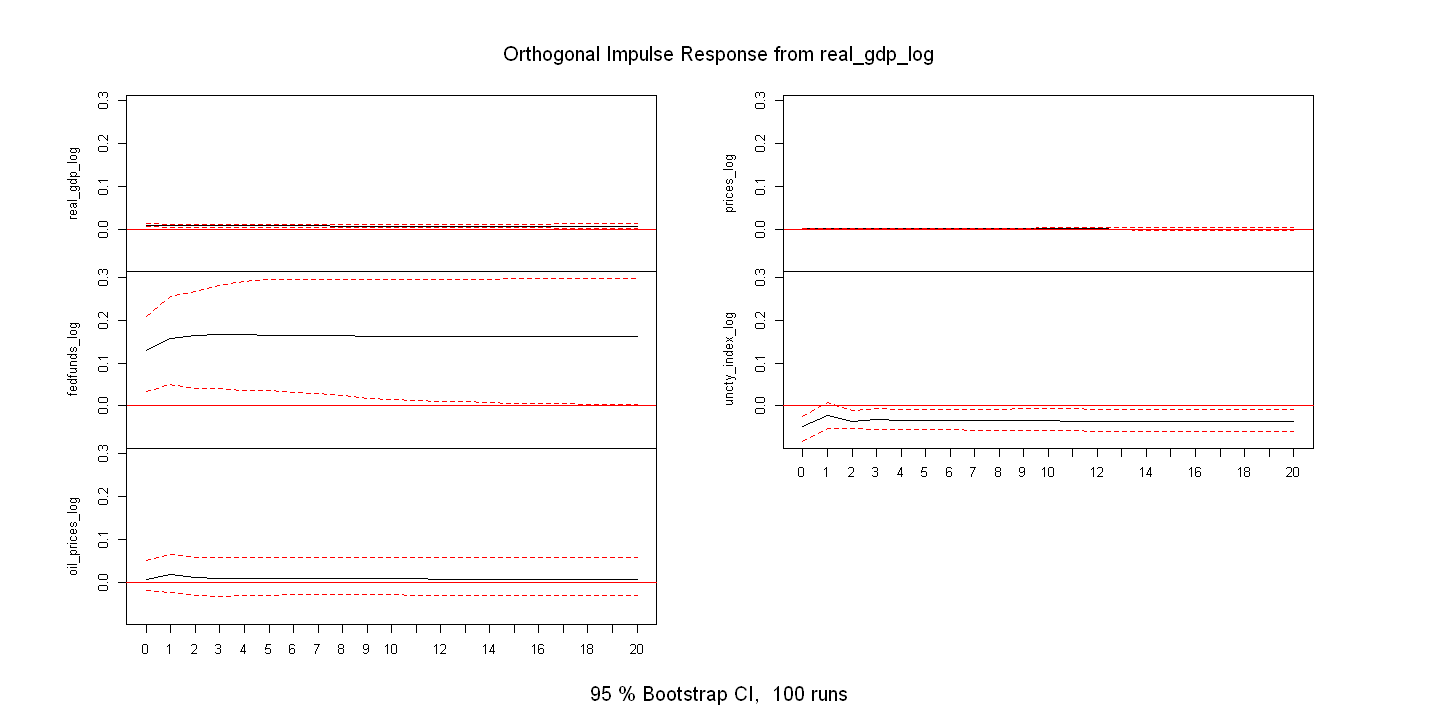

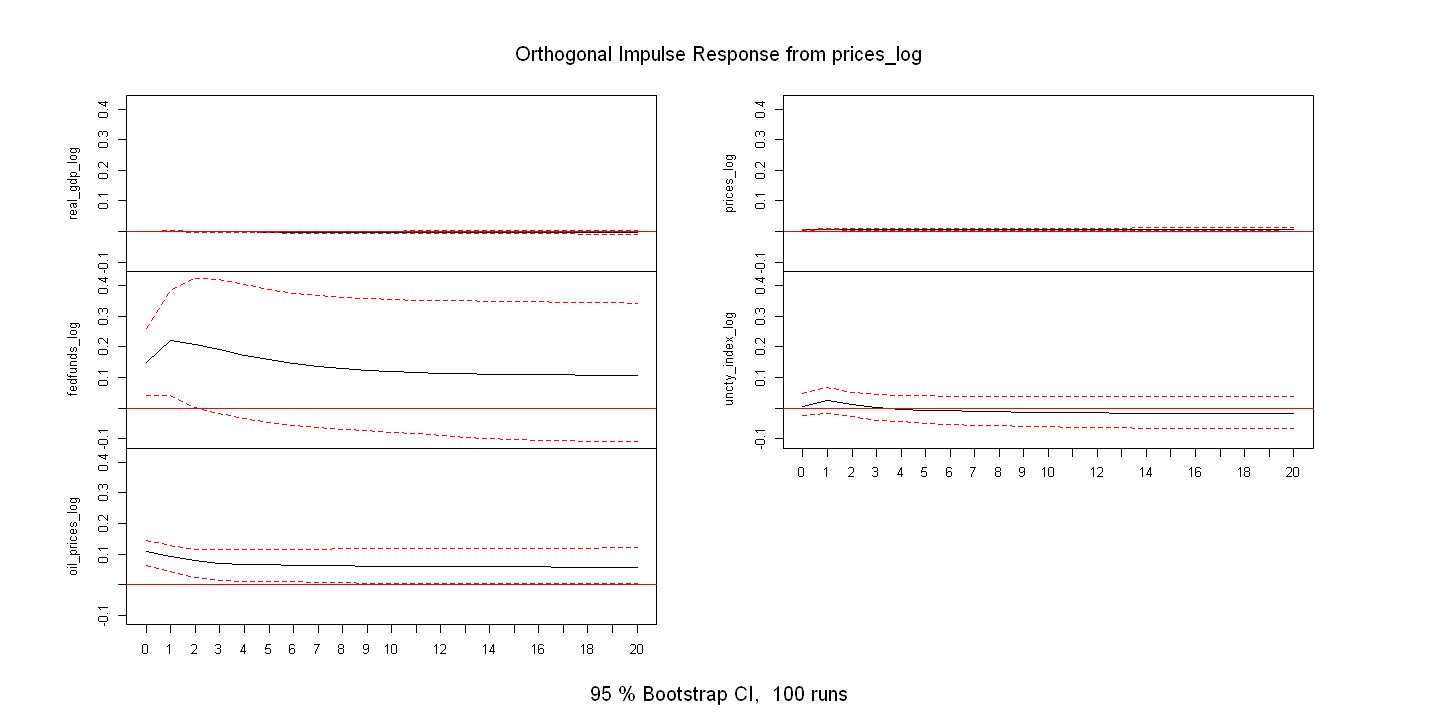

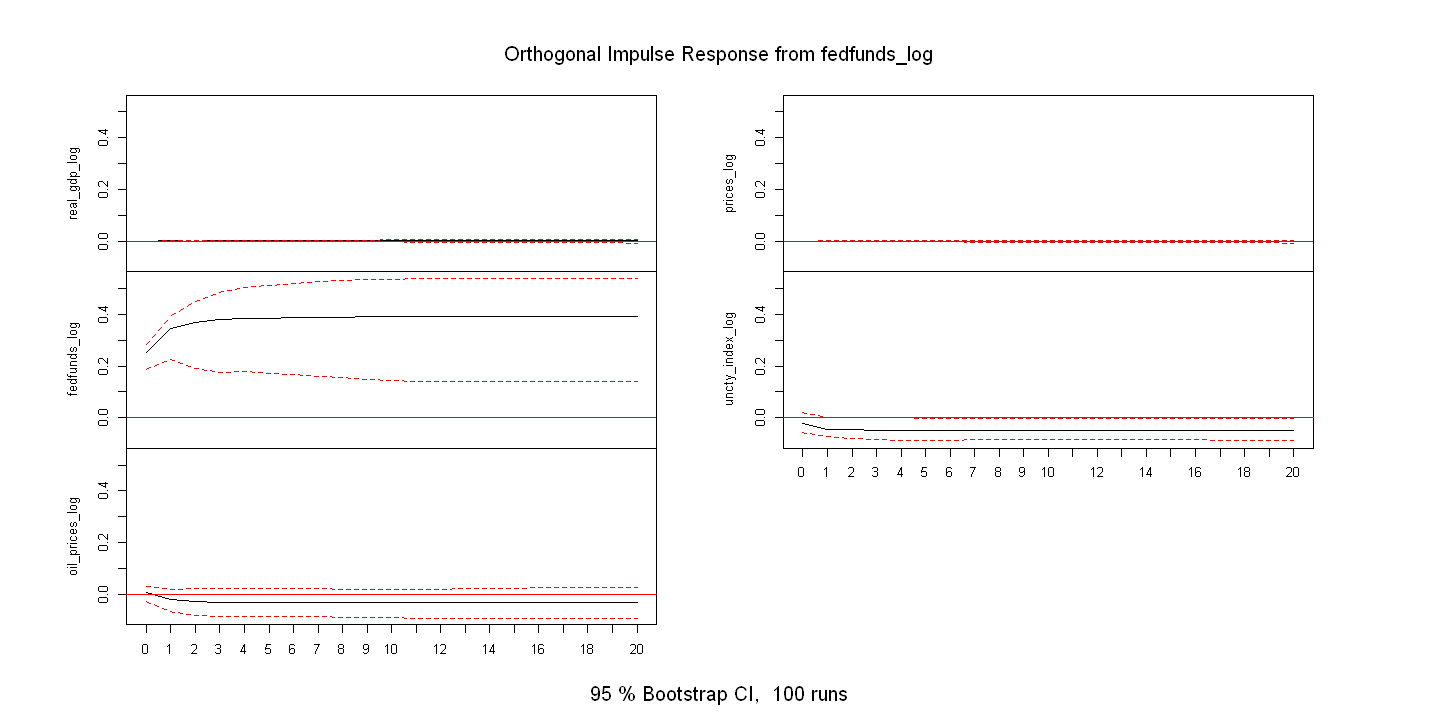

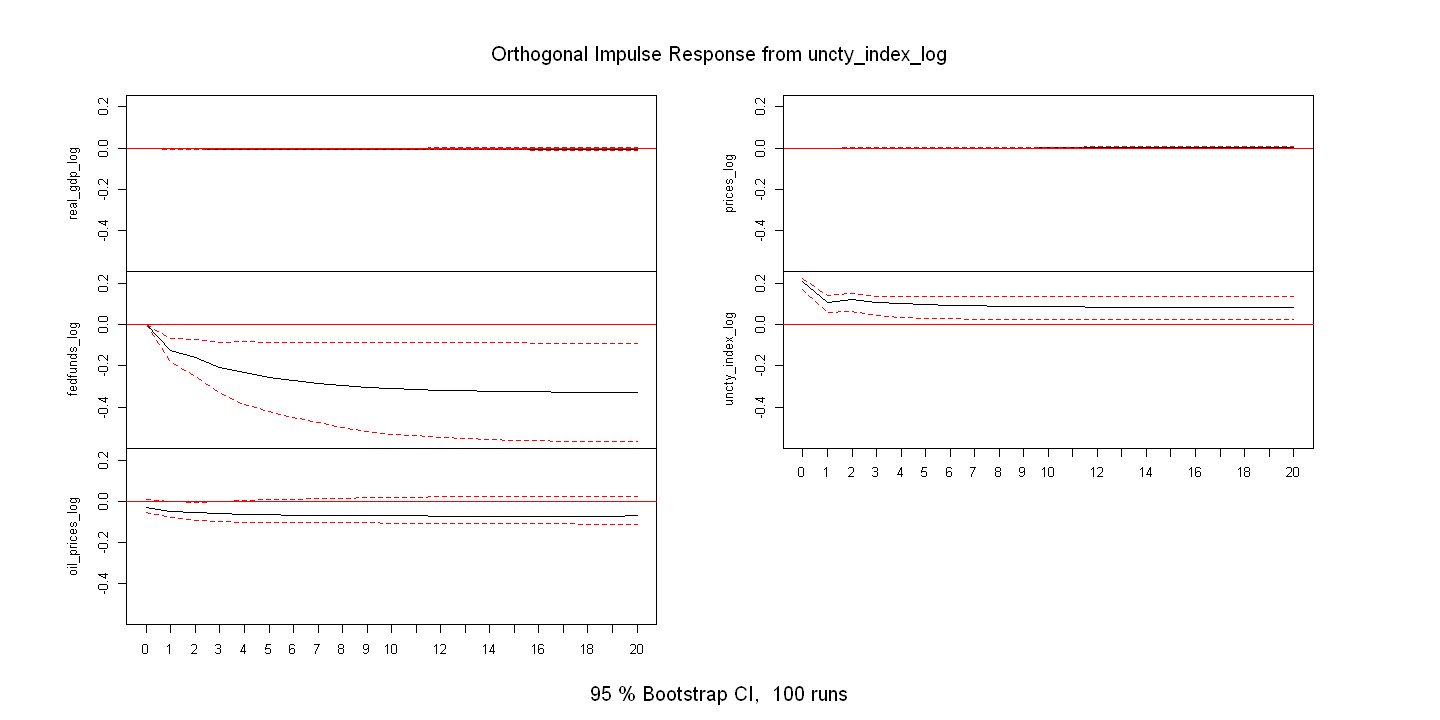

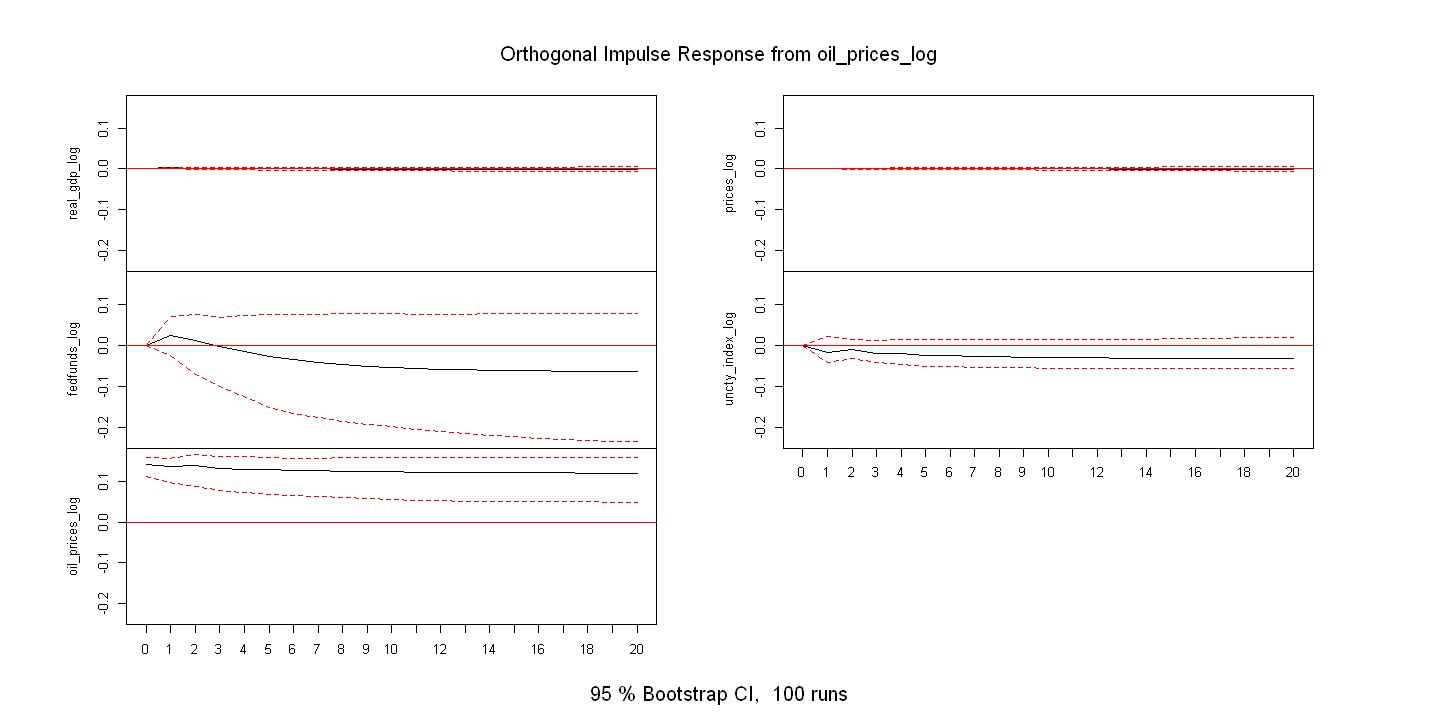

In [37]:
vecm2irf <- irf(vecm_var2, n.ahead = 20)
plot(vecm2irf)

The response of real GDP to an oil price shock is positive for the first few periods, with a peak at an early period (probably around 2-3). This suggests that an **increase in oil prices initially has a positive impact on real GDP**, but the effect diminishes over time.

The response of prices to an oil price shock is also positive and peaks very early, which should mean **higher oil prices lead to an increase in the general price level, which is consistent with the theory** that oil price shocks can cause inflation.

As for the new variable in the model (compared to the last part), the **federal funds rate**, its **response to an oil price shock is negative** in the first few periods. This suggests that the **central bank initially lowers the interest rate in response to higher oil prices**, perhaps in an attempt to mitigate the negative impact on economic growth.

Lastly, we can see an interesting response of the uncertainty index to an oil price shock. The uncertainty index is negative in the first few periods, which could mean that an **increase in oil prices tends to reduce economic uncertainty in the short run**. However, the effect reverses and becomes positive after roughly 2 years, suggesting that the initial reduction in uncertainty may be temporary.

As a last part of the VECM section, let us run some forecasts.

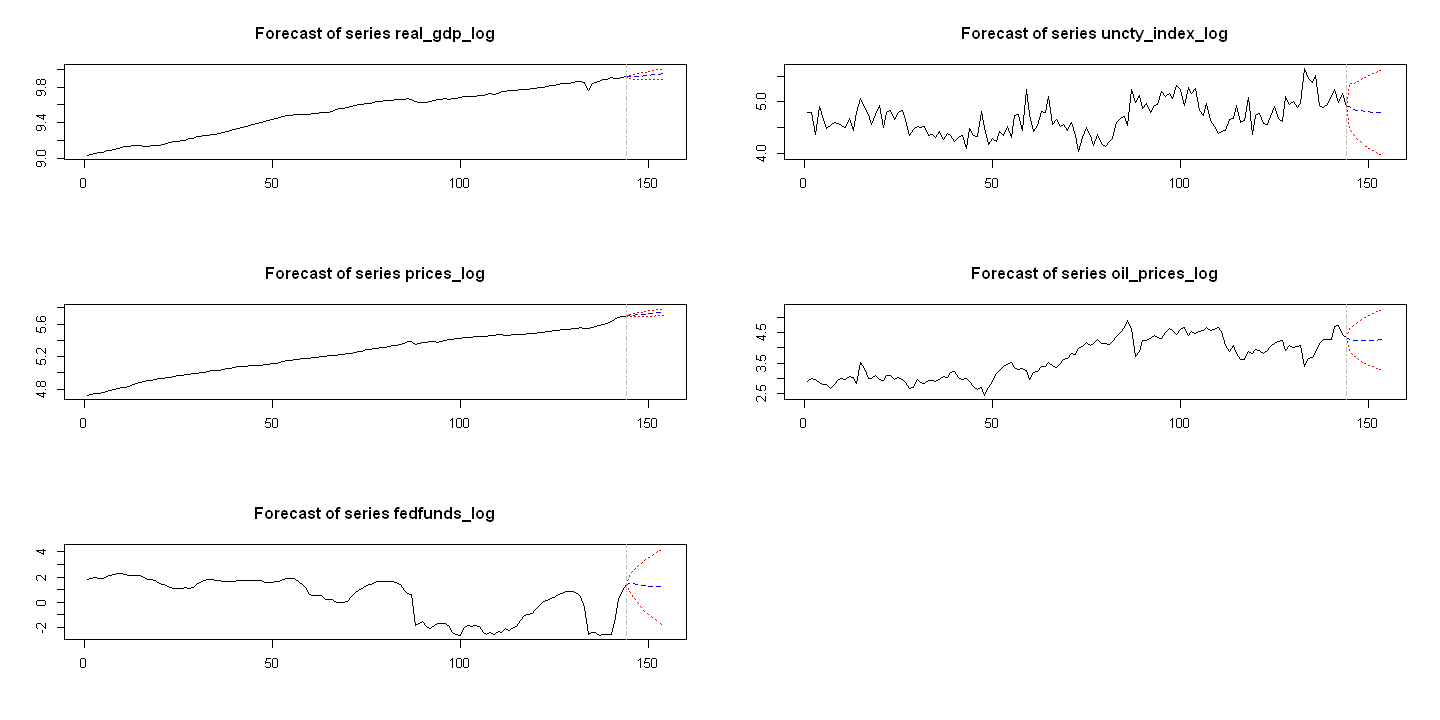

In [40]:
# Forecasts with VECM
plot(predict(vecm_var2))

The one and immediately only visible change in the forecasts compared to the simple VAR in levels is the direction of the oil prices forecast. While in the previous section the series was predicted to have a uniformly downwards trend, in this case, **the prediction is** (at least from an unqualified perspective) **more in line with the series' overall behavior** - slight, but constant growth over long periods of time. 

All in all, we could say that this model brings to the table more robust results than its alternatives.

### 3) Bayesian VAR

For the next section, we will try to estimate the series' behavior using *Bayesian VAR*. Given that we are no longer dealing with VAR in levels, we will be working with the differenced data (but not from the stage 2 as suggested, but our new, more robust data, with the *FEDFUNDS* series). These data are stored under the variable `data_var_3rd`.

We will employ virtually the identical setup as the one used during the lessons, given that we are dealing with much the similar data. As such, we too will opt for 6 lags for the estimation.

In [48]:
# Minnesota prior with the setup suggested from the lessons
mn_l <- bv_minnesota(
  lambda = bv_lambda(mode = 0.2, sd = 0.4, min = 0.0001, max = 5), #sets the prior for the tightness (lambda)
  alpha = bv_alpha(mode =2), #shrinkage parameter alpha set to 2
  var = 1e07) #large variance on constant

# Define the priors
priors <- bv_priors(hyper = "auto", mn = mn_l)

#some adjustment to the Metropolis-Hastings algorithm needed to obtain reasonable number of accepted draws
mh <- bv_metropolis(scale_hess = c(0.05),
      adjust_acc = TRUE, acc_lower = 0.25, acc_upper = 0.45)

# Run the BVAR estimation
bvar1 <- bvar(data_var_3rd, lags = 6, n_draw = 15000L, n_burn = 5000L, n_thin = 10L, priors = priors, mh = mh, verbose = FALSE)
summary(bvar1)

Bayesian VAR consisting of 138 observations, 5 variables and 6 lags.
Time spent calculating: 9.77 secs
Hyperparameters: lambda 
Hyperparameter values after optimisation: 0.45104
Iterations (burnt / thinning): 15000 (5000 / 10)
Accepted draws (rate): 3202 (0.32)

Numeric array (dimensions 31, 5) of coefficient values from a BVAR.
Median values:
                       gdp_growth inflation fedfunds uncertainty_index
constant                   -0.024    -0.013    0.001             0.022
gdp_growth-lag1             0.674     0.033   -0.081             0.044
inflation-lag1             -0.137     0.091   -0.158             0.123
fedfunds-lag1               0.039    -0.119    0.392            -0.153
uncertainty_index-lag1     -0.192    -0.141   -0.284            -0.438
oil_prices-lag1             0.278     0.247    0.229            -0.041
gdp_growth-lag2             0.096     0.128   -0.036             0.059
inflation-lag2             -0.014     0.109    0.004             0.015
fedfunds-lag2  

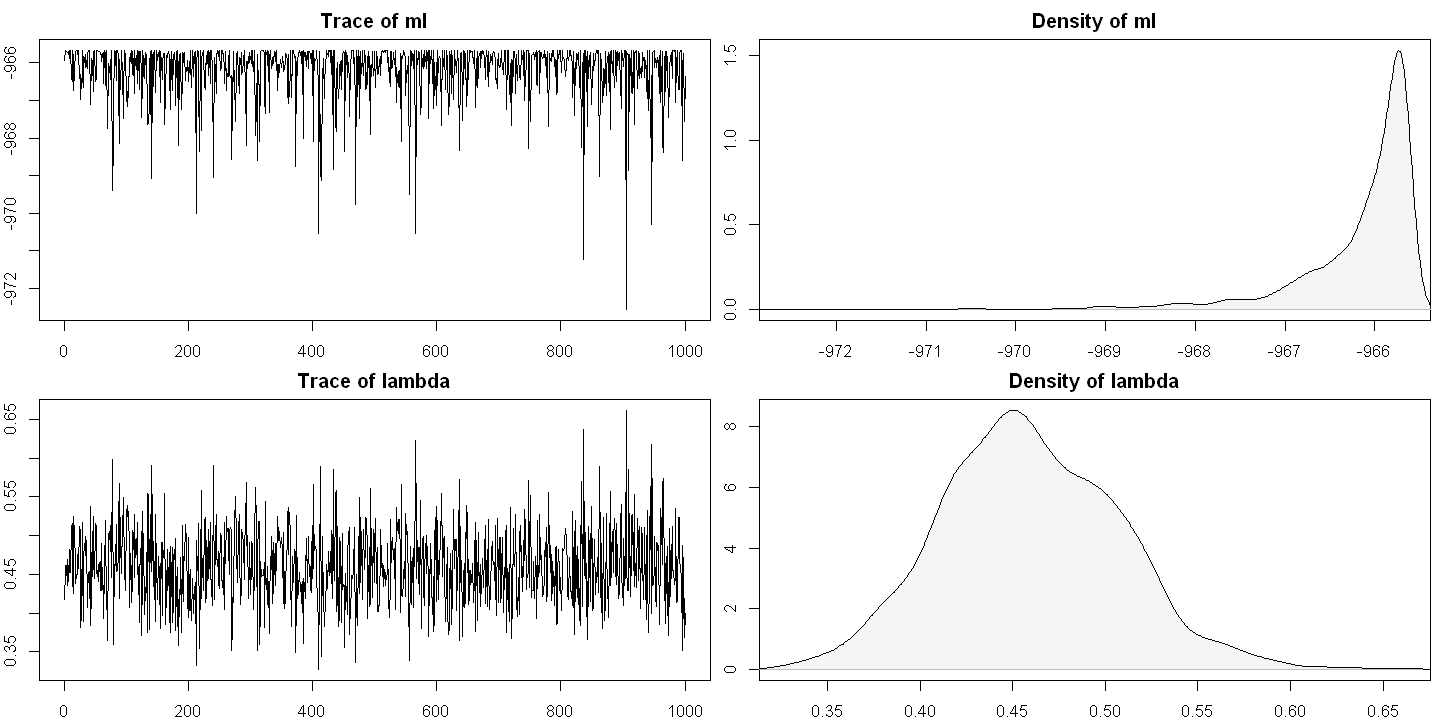

In [49]:
# Get the diagnostic plots for the BVAR
plot(bvar1)

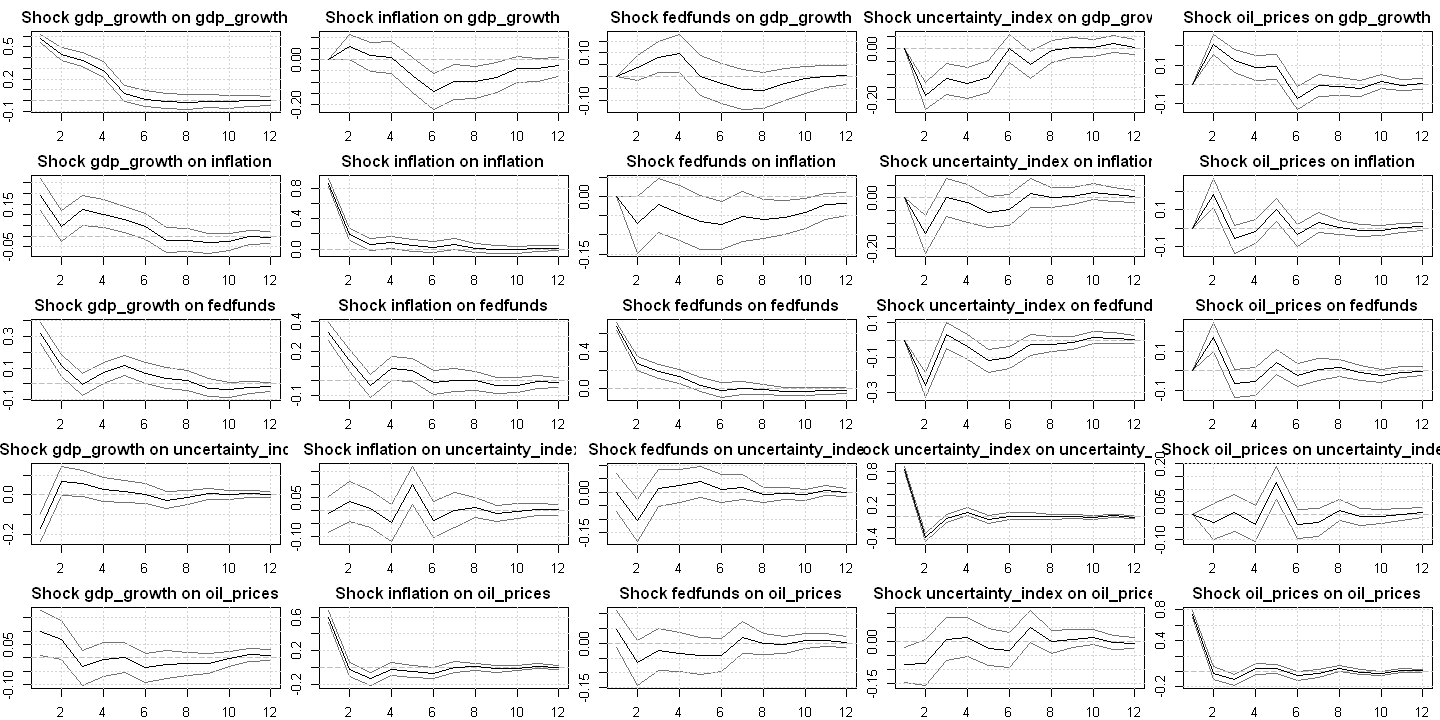

In [51]:
# Plot the Impulse Response Functions
plot(irf(bvar1))

The results seems quite stable at first glance. We will not delve deep into the individual coefficients from the BVAR, and will instead focus more on the comparison of the IRFs to the ones we obtained during the VAR in levels and VECM estimation.

The response of GDP to oil prices behaves virtually the same as it did with the VECM, as does the response of inflation.

On the other hand, the **impact of an oil prices shock on both federal funds rate and uncertainty index is quite different**. BVAR predicts an strong positive early response of the central bank, which is a little counter intuitive. Similarly, the sudden peak in the uncertainty index reponse around period 5 is hard to explain intuitively, and may just be caused by fluctuations in the data or a setup specification.

Generally speaking, the **results are quite similar to the ones we obtained during VECM estimation**. We can thus claim that these conclusions are the most robust out of the ones we have made thus far.

As the next step, we will run a few forecasts.

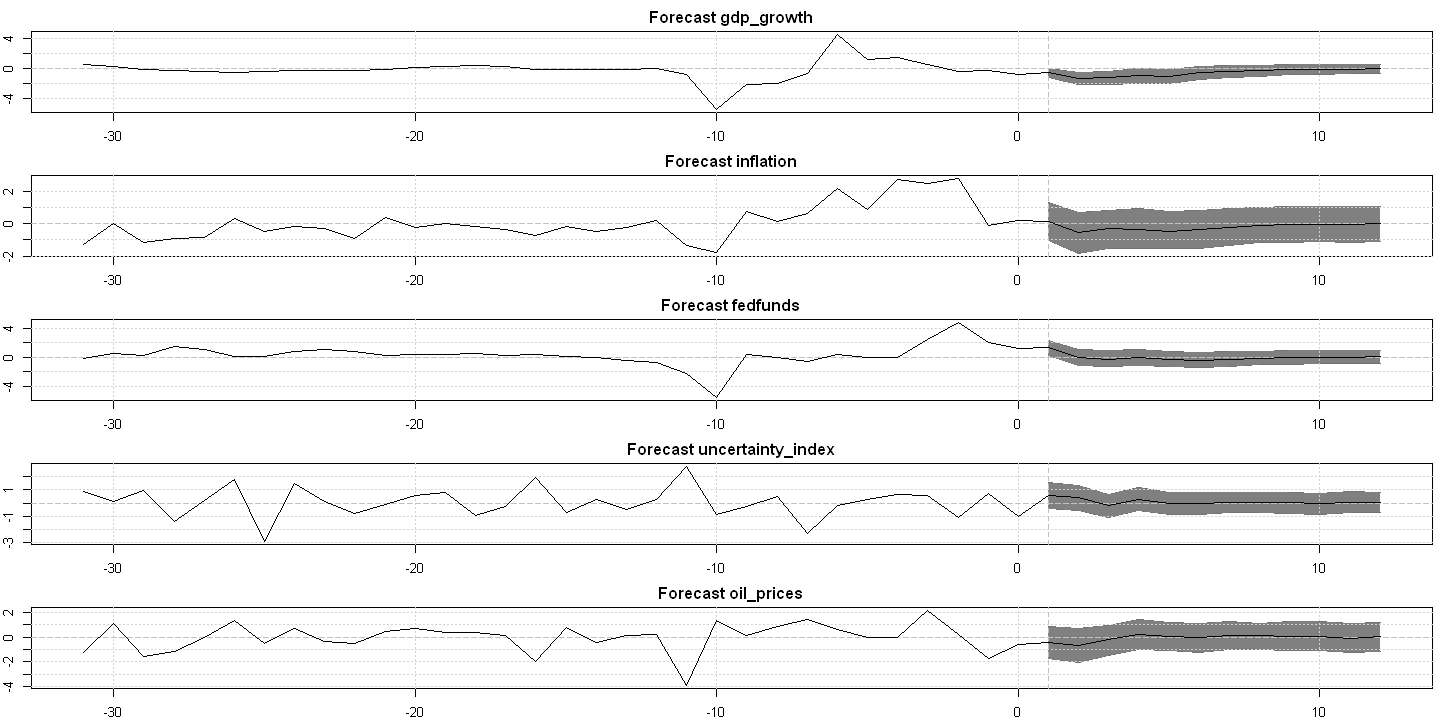

In [59]:
predict(bvar1) <- predict(bvar1)
plot(predict(bvar1), area = TRUE, t_back = 32)

Given that we are not dealing with level data anymore (as we have been explicitely asked to estimate the procedure on data/model from the second part of the task), it is difficult to make direct comparisons.

Nonetheless, the forecast for **inflation is**, even though only slightly, **predicted to stay below 0** for most of the time, as is the case with GDP growth. Oil prices, uncertainty index, and fed funds are expected all to change very little (prediction near 0).

### 4) Local Projections

As a last part of the exercise, we will construct several *local projections*.